# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we start the predictive analysis using machine and deep learning techniques.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Load the Dataset

As a first step we reload the full dataset used for the EDA:

In [4]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda.csv')

# drop the first solution (too correlated to the output)
df = df.loc[df['solutions'] != 0]

## Validation Strategy

We then retain 10% of the total dataset as test set.
We then use a linear model to determine the best tradeoff between the size of the validation set and the MSE.
As we did before, we split the unique solutions into the sets and only then assign the corresponding samples.

In [5]:
from sklearn.model_selection import train_test_split

sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, test_size=0.1, shuffle=True, random_state=RAND)

# divide into training and test set
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

Define the linear model to be used:

In [6]:
import os
os.makedirs('./models', exist_ok=True)

In [7]:
from sklearn.linear_model import LinearRegression
import joblib

estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)

# save the model to file
joblib.dump(estimator, './models/lr_valsize.pkl')

['./models/lr_valsize.pkl']

Train the model on different splits of the validation set and compute the MSE:

In [8]:
import json
import numpy as np

val_sizes = np.linspace(0.1, 0.9, 17)
errors    = []

for size in val_sizes:

    sol_train_tmp, sol_val_tmp = train_test_split(sol_train, test_size=size, shuffle=False)

    # define the sets
    df_train_tmp = df_train.loc[df_train['solutions'].isin(sol_train_tmp)].sample(frac=1, random_state=RAND)
    df_val_tmp   = df_train.loc[df_train['solutions'].isin(sol_val_tmp)].sample(frac=1, random_state=RAND)

    exp_train_tmp = df_train_tmp['exp']
    exp_val_tmp   = df_val_tmp['exp']

    df_train_tmp = df_train_tmp.drop(columns=['solutions', 'init', 'exp'])
    df_val_tmp   = df_val_tmp.drop(columns=['solutions', 'init', 'exp'])

    # save the sets to file
    exp_train_tmp.to_csv('./data/lr_valsize_lab_train_tmp.csv', index=False)
    exp_val_tmp.to_csv('./data/lr_valsize_lab_val_tmp.csv', index=False)
    df_train_tmp.to_csv('./data/lr_valsize_train_tmp.csv', index=False)
    df_val_tmp.to_csv('./data/lr_valsize_val_tmp.csv', index=False)

    # train the estimator
    !python3 ./scripts/scikit-train.py -t './data/lr_valsize_train_tmp.csv' \
                                       -l './data/lr_valsize_lab_train_tmp.csv' \
                                       -e './models/lr_valsize.pkl' > /dev/null

    # compute metrics and predictions
    !python3 ./scripts/scikit-predict.py -t './data/lr_valsize_train_tmp.csv' \
                                         -l './data/lr_valsize_lab_train_tmp.csv' \
                                         -e './models/lr_valsize.pkl' \
                                         -o 'lr_valsize_train' > /dev/null
    
    !python3 ./scripts/scikit-predict.py -t './data/lr_valsize_val_tmp.csv' \
                                         -l './data/lr_valsize_lab_val_tmp.csv' \
                                         -e './models/lr_valsize.pkl' \
                                         -o 'lr_valsize_val' > /dev/null

    # read the metrics file
    with open('./metrics/lr_valsize_train.json', 'r') as f:
        metrics_train = json.load(f)
    with open('./metrics/lr_valsize_val.json', 'r') as f:
        metrics_val = json.load(f)

    errors.append((size, np.round(metrics_train['MSE'], 3), np.round(metrics_val['MSE'], 3)))

# save the errors to file
errors = pd.DataFrame(errors, columns=['size', 'training', 'validation'])
errors.to_csv('./metrics/lr_valsize_mse.csv', index=False)

In [9]:
INPUT  = './metrics/lr_valsize_mse.csv'
OUTPUT = 'valsize_errors'

!python3 ./scripts/val_size_errors.py --errors {INPUT} --output {OUTPUT}

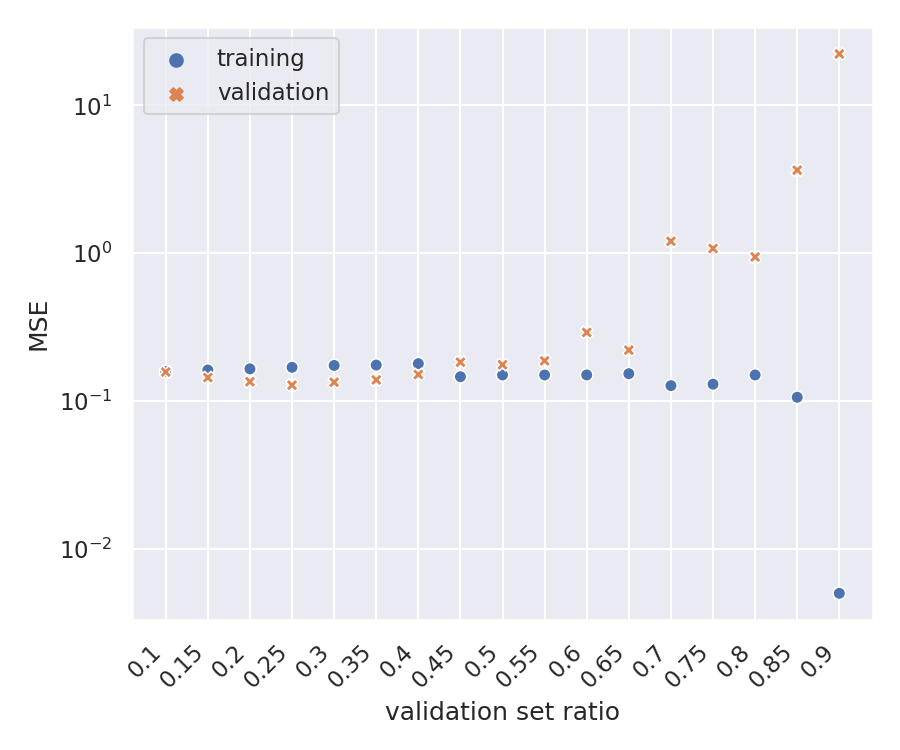

In [10]:
from IPython.display import Image
Image('./img/valsize_errors.png', width=480)

Given the results we choose to keep 10% of data into the test set, 10% into the validation set and the rest for training:

In [11]:
import sklearn
from sklearn.preprocessing import RobustScaler
import joblib

def rescale(df: pd.DataFrame,
            scl: sklearn.base.BaseEstimator,
            train: bool = False
           ) -> pd.DataFrame:
    '''
    Rescale the truncation levels only.
    
    Required arguments:
        df:    the dataframe,
        scl:   the scaler,
        train: whether df is training set.
        
    Returns:
        the scaler and the scaled dataframe.
    '''
    df_p1 = df[['weight', 'type']]
    df_p2 = df.filter(regex='^level_.*')
    
    if train:
        df_p2 = pd.DataFrame(scaler.fit_transform(df_p2), columns=df_p2.columns)
    else:
        df_p2 = pd.DataFrame(scaler.transform(df_p2), columns=df_p2.columns)
        
    # reset indices
    df_p1 = df_p1.reset_index(drop=True)
    df_p2 = df_p2.reset_index(drop=True)
        
    df = pd.concat([df_p1, df_p2], axis=1)
    
    return scaler, df

sol_train, sol_val = train_test_split(sol_train, test_size=0.1, shuffle=True, random_state=RAND)

# separate training and validation sets
df_val   = df_train.loc[df_train['solutions'].isin(sol_val)]
df_train = df_train.loc[df_train['solutions'].isin(sol_train)]

# save the labels to file
lab_train = df_train['exp']
lab_train.to_csv('./data/lab_train.csv', index=False)
lab_val = df_val['exp']
lab_val.to_csv('./data/lab_val.csv', index=False)
lab_test = df_test['exp']
lab_test.to_csv('./data/lab_test.csv', index=False)

# save the sets to file after scaling
scaler = RobustScaler()

df_train = df_train.drop(columns=['solutions', 'init', 'exp'])
scaler, df_train = rescale(df_train, scaler, train=True)
df_train.to_csv('./data/train.csv', index=False)
joblib.dump(scaler, './models/scaler.pkl')

df_val = df_val.drop(columns=['solutions', 'init', 'exp'])
_, df_val = rescale(df_val, scaler, train=False)
df_val.to_csv('./data/val.csv', index=False)

df_test = df_test.drop(columns=['solutions', 'init', 'exp'])
_, df_test = rescale(df_test, scaler, train=False)
df_test.to_csv('./data/test.csv', index=False)

In [12]:
print('Training set effective size: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))
print('Training set effective size: {:.2f}%'.format(100 * df_val.shape[0] / df.shape[0]))
print('Training set effective size: {:.2f}%'.format(100 * df_test.shape[0] / df.shape[0]))

Training set effective size: 79.81%
Training set effective size: 9.33%
Training set effective size: 10.86%


Set useful constants:

In [13]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'
TEST = './data/test.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'
LAB_TEST   = './data/lab_test.csv'

## Linear Regression

We first analyse the effect of linear regression with $\ell_2$ regularisation. We define the estimator and then perform the optimisation:

In [14]:
from sklearn.linear_model import Ridge
import joblib

# choose the estimator
estimator = Ridge(random_state=RAND)

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/ridge.pkl']

We then define the hyperparameters for the optimisation:

In [15]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1.0e-3, 1.0e2, prior='log-uniform', name='alpha')]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/ridge_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [16]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

Ridge optimised in 34.815 seconds.
Ridge trained in 0.002 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [17]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,alpha,10.103696


The trained estimator is therefore:

In [18]:
import joblib

joblib.load(ESTIMATOR)

Ridge(alpha=10.103695974700006, random_state=123)

After training, we then compute the predictions and the metrics:

In [19]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

Ridge predicted in 0.009 seconds.
Ridge predicted in 0.001 seconds.
Ridge predicted in 0.001 seconds.


In [20]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ridge_train,554,0.175110,0.134216,0.216004,0.418462,0.305675,0.649518
ridge_val,48,0.107859,0.066867,0.148850,0.328419,0.268393,0.776258
ridge_test,59,0.160201,0.073486,0.246917,0.400251,0.292234,0.683551


Finally we produce all the necessary plots and display them:

In [21]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

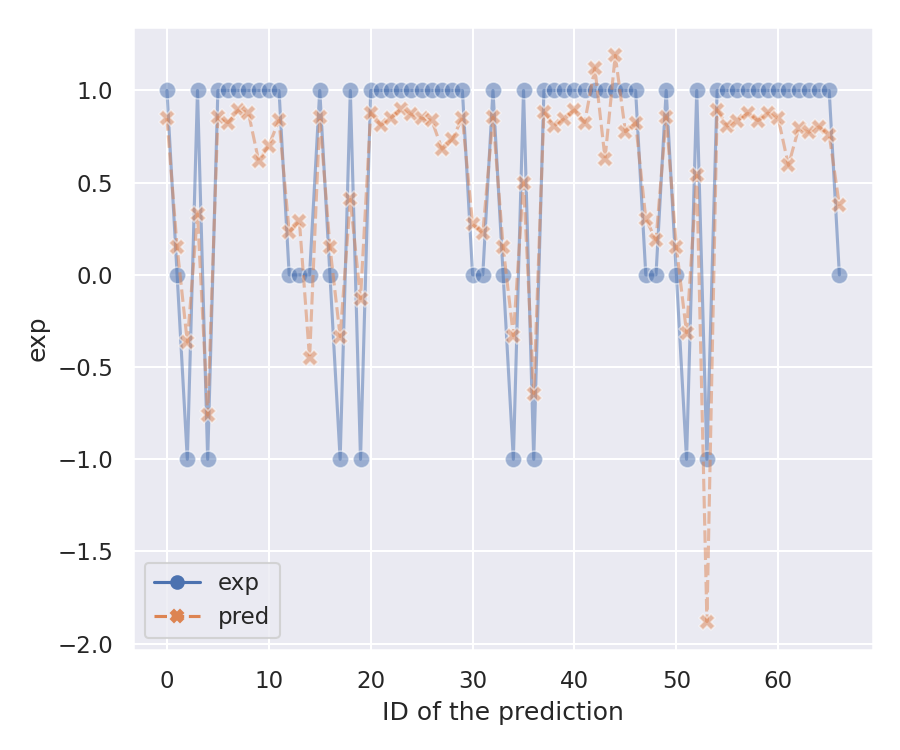

In [22]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

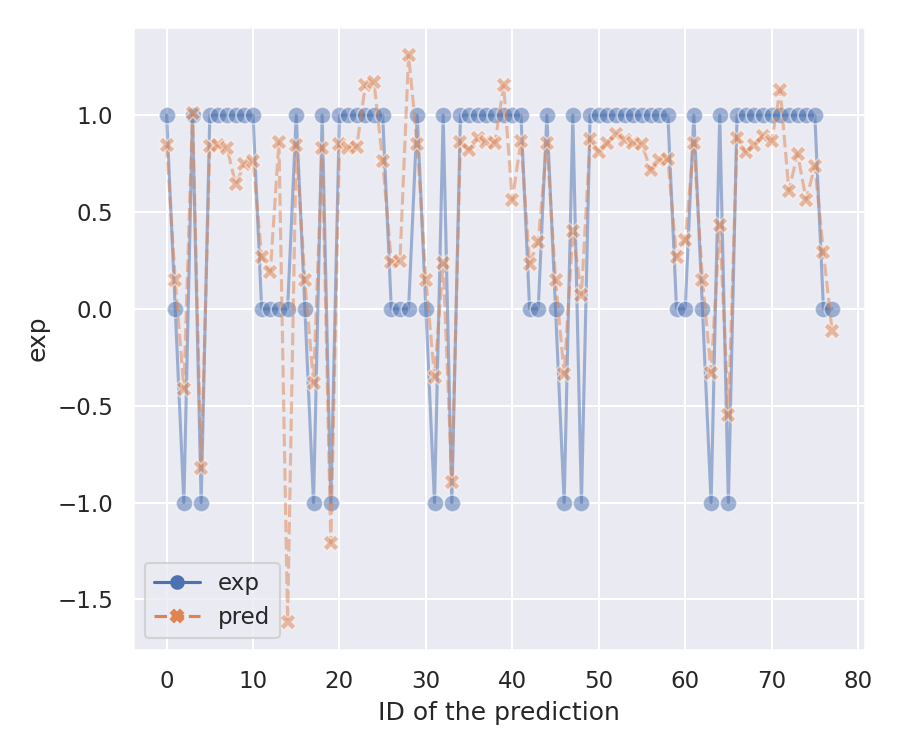

In [23]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

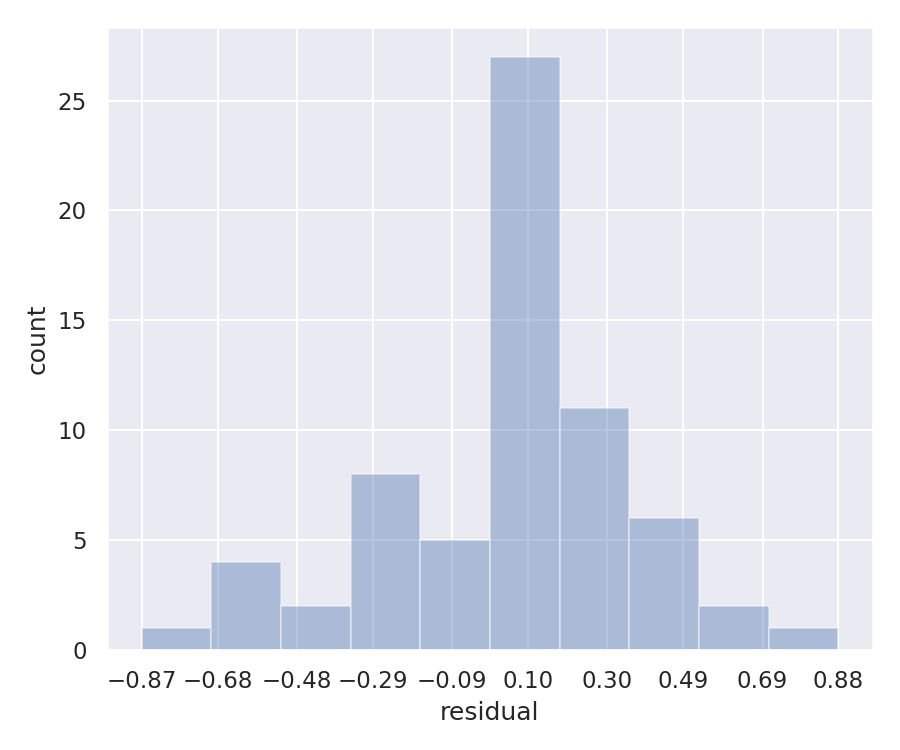

In [24]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

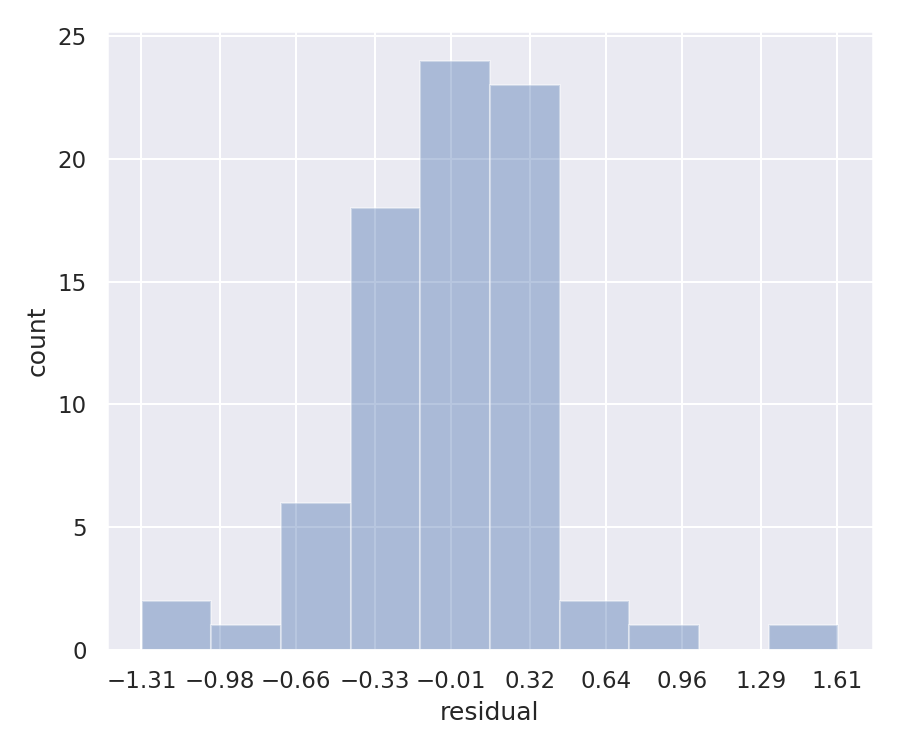

In [25]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

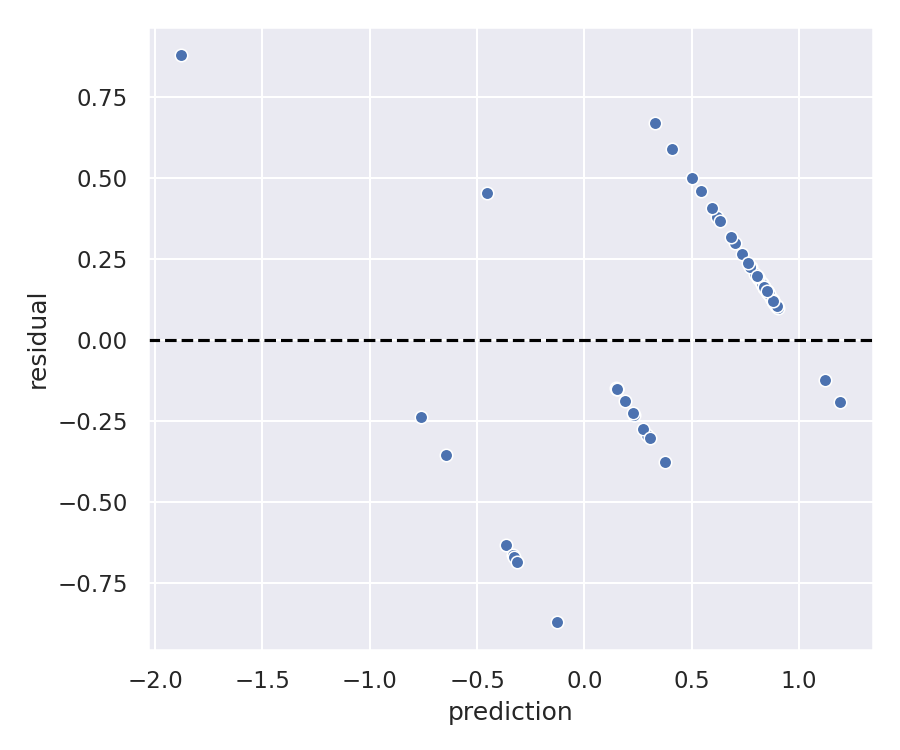

In [26]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

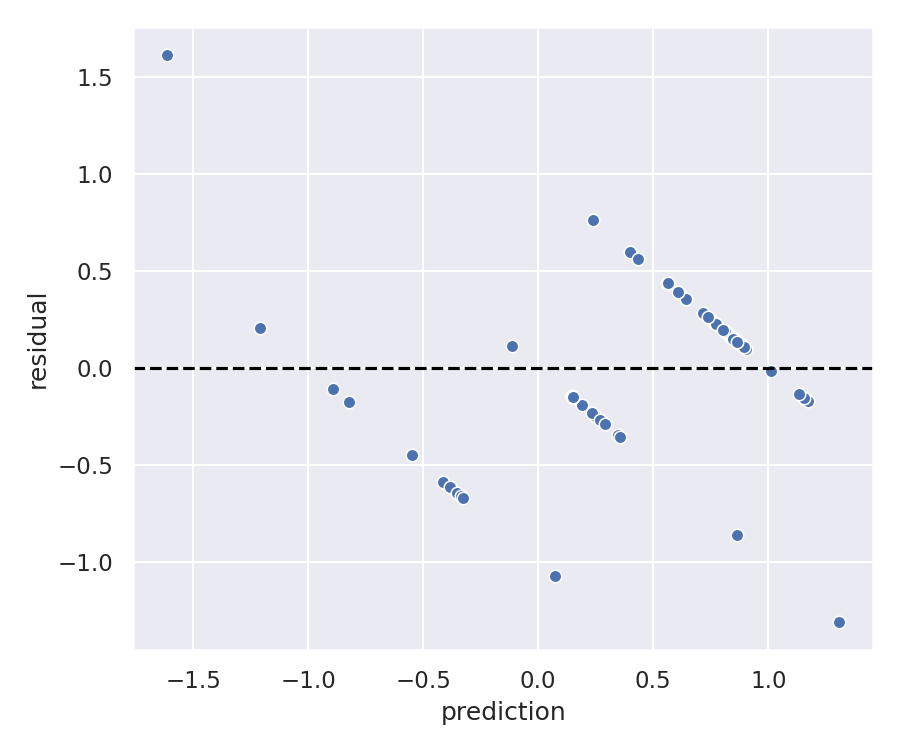

In [27]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [28]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.001 seconds.
Trained ratio 0.20 in 0.001 seconds.
Trained ratio 0.30 in 0.001 seconds.
Trained ratio 0.40 in 0.001 seconds.
Trained ratio 0.50 in 0.001 seconds.
Trained ratio 0.60 in 0.001 seconds.
Trained ratio 0.70 in 0.001 seconds.
Trained ratio 0.80 in 0.001 seconds.
Trained ratio 0.90 in 0.001 seconds.
Learning curve for Ridge trained in 0.077 seconds.


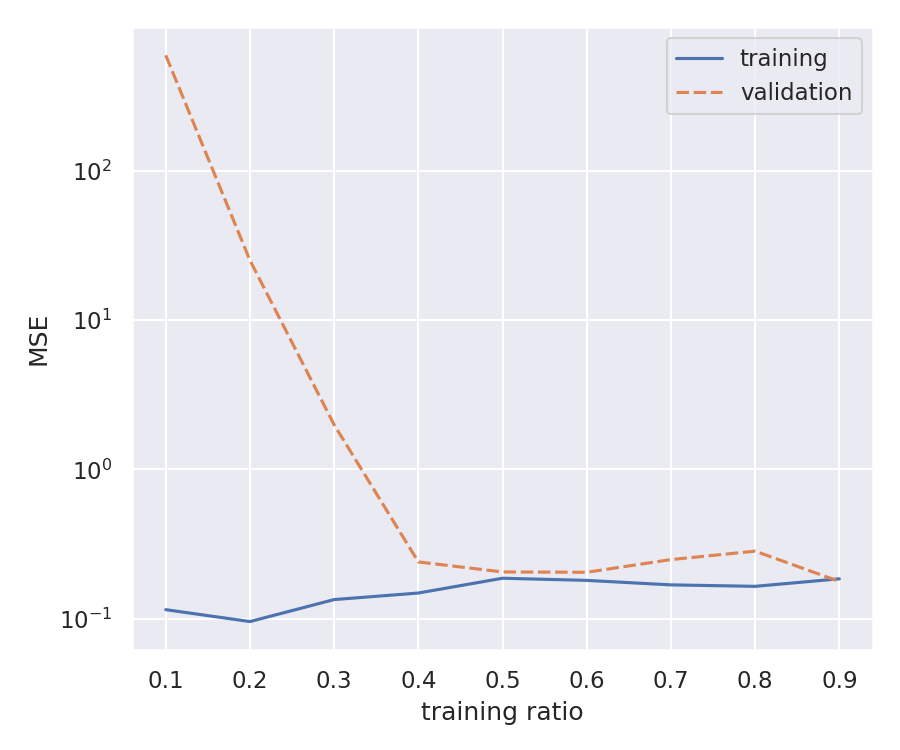

In [29]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Linear SVM

We remain in the family of linear models but we start considering the support vector machine (SVM) version (w/o _kernel trick_).

In [30]:
from sklearn.svm import LinearSVR
import joblib

# choose the estimator
estimator = LinearSVR(random_state=RAND, max_iter=1e6)

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/linearsvr.pkl']

We then define the hyperparameters for the optimisation:

In [31]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1.0e-4, 1.0e-1, prior='log-uniform', name='epsilon'),
          Real(1.0e-1, 1.0e3, prior='log-uniform', name='C'),
          Categorical(['epsilon_insensitive',
                       'squared_epsilon_insensitive'
                      ],
                      name='loss'
                     )
         ]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/linearsvr_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [32]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/sit

After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [33]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,epsilon,0.1
1,C,0.5586093876080802
2,loss,squared_epsilon_insensitive


The trained estimator is therefore:

In [34]:
import joblib

joblib.load(ESTIMATOR)

LinearSVR(C=0.5586093876080802, epsilon=0.1, loss='squared_epsilon_insensitive',
          max_iter=1000000.0, random_state=123)

After training, we then compute the predictions and the metrics:

In [35]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LinearSVR predicted in 0.009 seconds.
LinearSVR predicted in 0.001 seconds.
LinearSVR predicted in 0.001 seconds.


In [36]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
linearsvr_train,554,2.474753,1.238591,3.710915,1.573135,0.476619,-3.953202
linearsvr_val,48,1.391596,-0.489780,3.272972,1.179659,0.388046,-1.886726
linearsvr_test,59,2.416208,-0.248586,5.081002,1.554416,0.487445,-3.772795


Finally we produce all the necessary plots and display them:

In [37]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

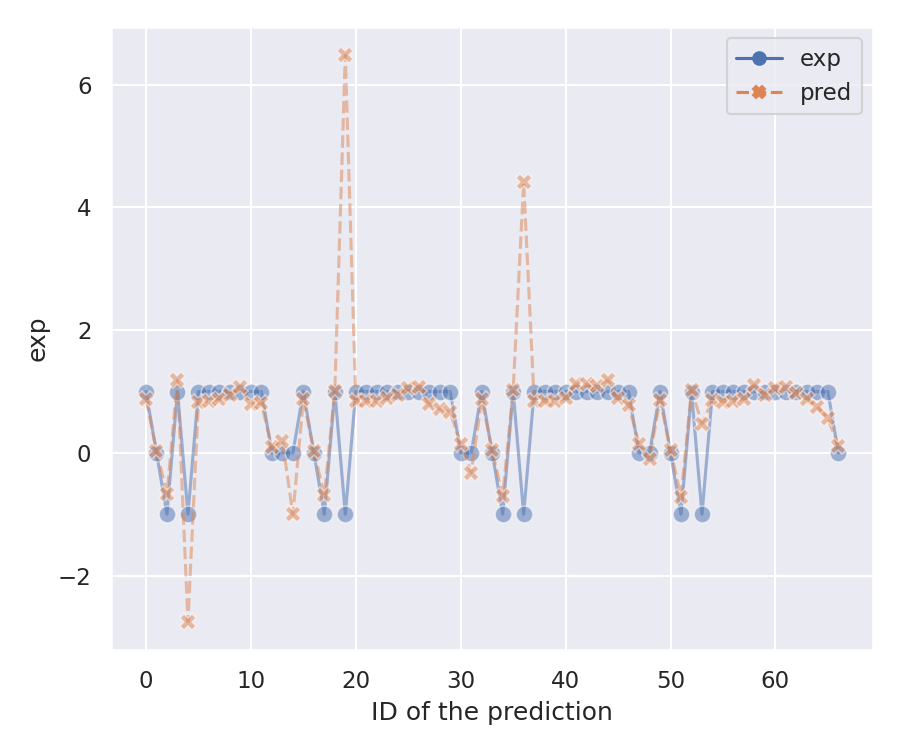

In [38]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

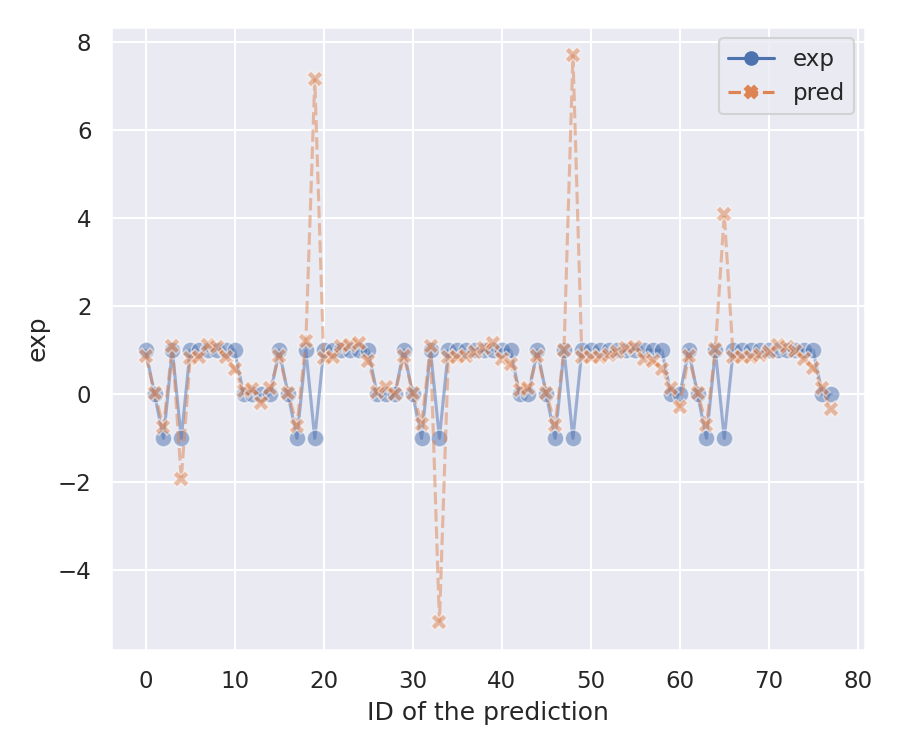

In [39]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

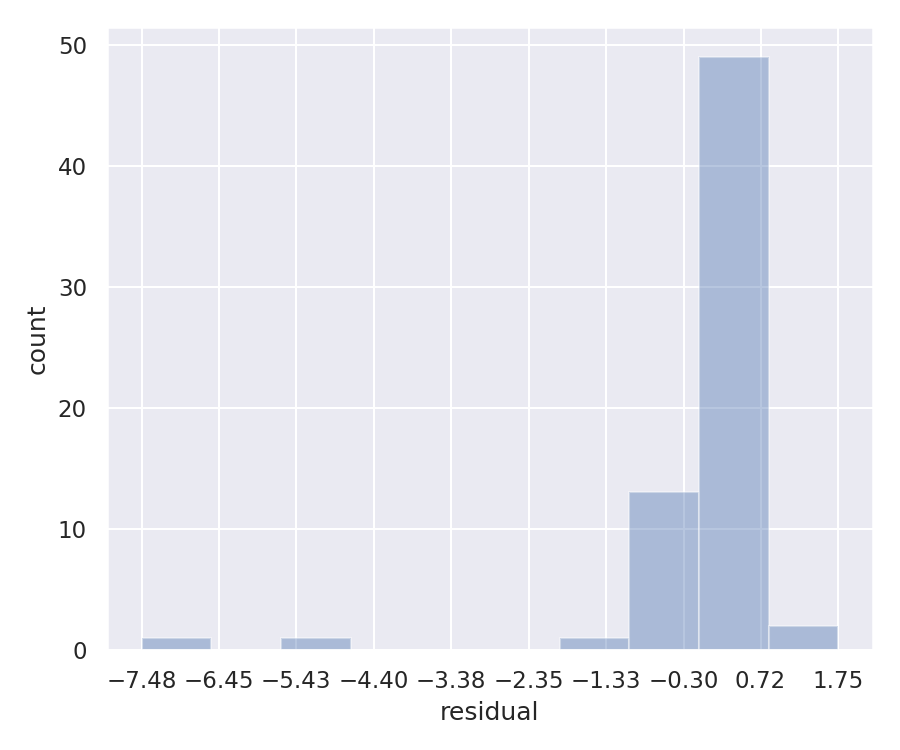

In [40]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

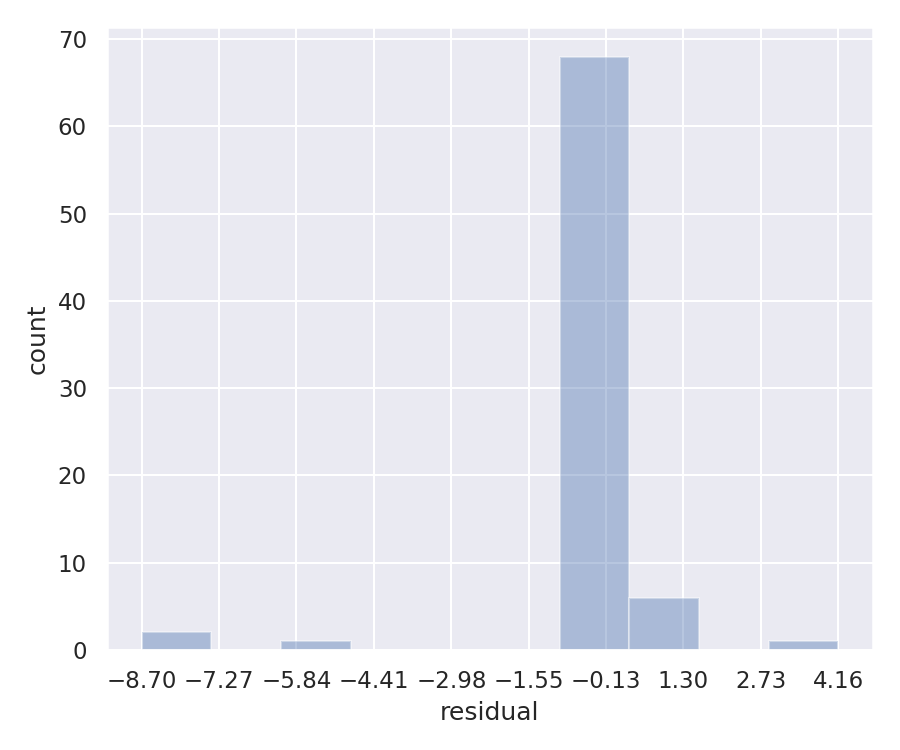

In [41]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

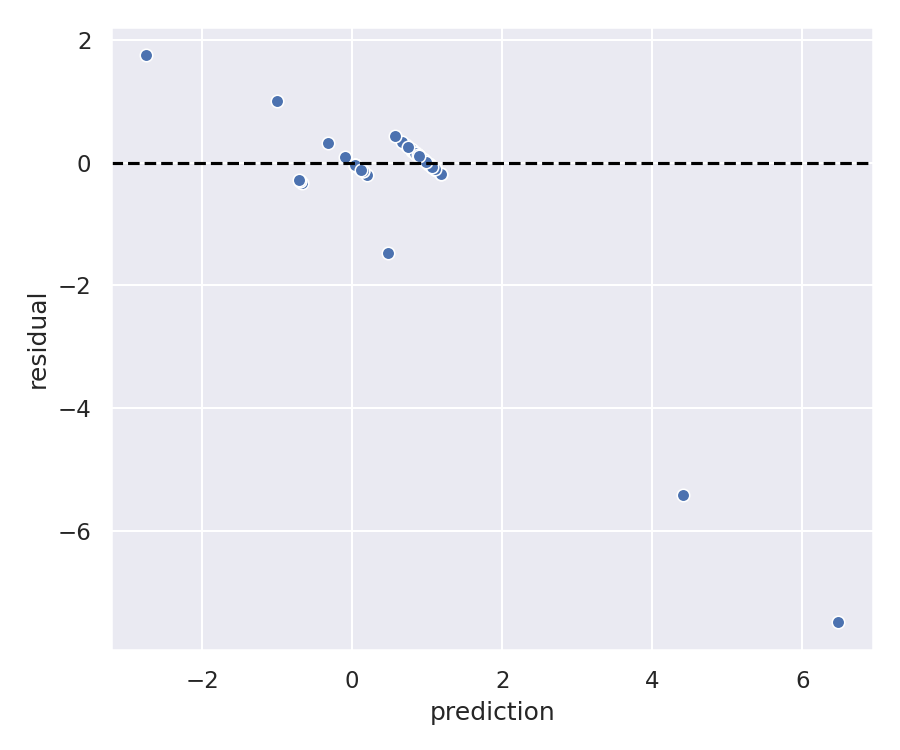

In [42]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

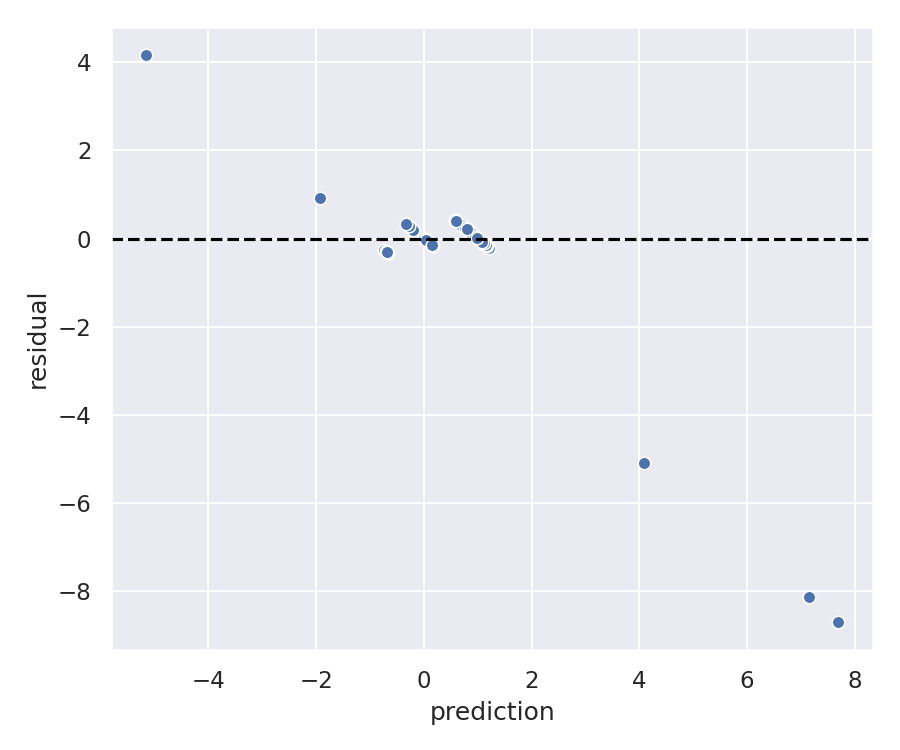

In [43]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [ ]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.10 in 2.477 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.20 in 5.536 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
Trained ratio 0.30 in 8.096 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [ ]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Gaussian SVM

We then change completely algorithms and use the _kernel trick_ (w/ Gaussian kernel) to compute the predictions.

In [ ]:
from sklearn.svm import SVR
import joblib

# choose the estimator
estimator = SVR(kernel='rbf')

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

We then define the hyperparameters for the optimisation:

In [ ]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Real(1e-5, 1e1, prior='log-uniform', name='gamma'),
          Real(1.0e-3, 1.0e1, prior='log-uniform', name='epsilon'),
          Real(1.0e-1, 1.0e3, prior='log-uniform', name='C')
         ]

# save the parameters
PARAMS = './models/{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

Finally we can run the Bayes optimisation procedure:

In [48]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

SVR optimised in 42.711 seconds.
SVR trained in 0.027 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [49]:
import pandas as pd

pd.read_csv('./hypers/{}.csv'.format(name))

,names,values
0,gamma,0.000017
1,epsilon,0.066081
2,C,1000.000000


The trained estimator is therefore:

In [50]:
import joblib

joblib.load(ESTIMATOR)

SVR(C=1000.0, epsilon=0.06608147522839085, gamma=1.6971948876192545e-05)

After training, we then compute the predictions and the metrics:

In [51]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

SVR predicted in 0.004 seconds.
SVR predicted in 0.001 seconds.
SVR predicted in 0.001 seconds.


In [52]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
svr_train,554,0.053227,0.025090,0.081363,0.230709,0.091608,0.893467
svr_val,48,0.019321,0.003548,0.035094,0.139000,0.080687,0.959921
svr_test,59,0.022149,0.007477,0.036822,0.148827,0.087089,0.956248


Finally we produce all the necessary plots and display them:

In [53]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = name + '_val'
OUTPUT_TEST = name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

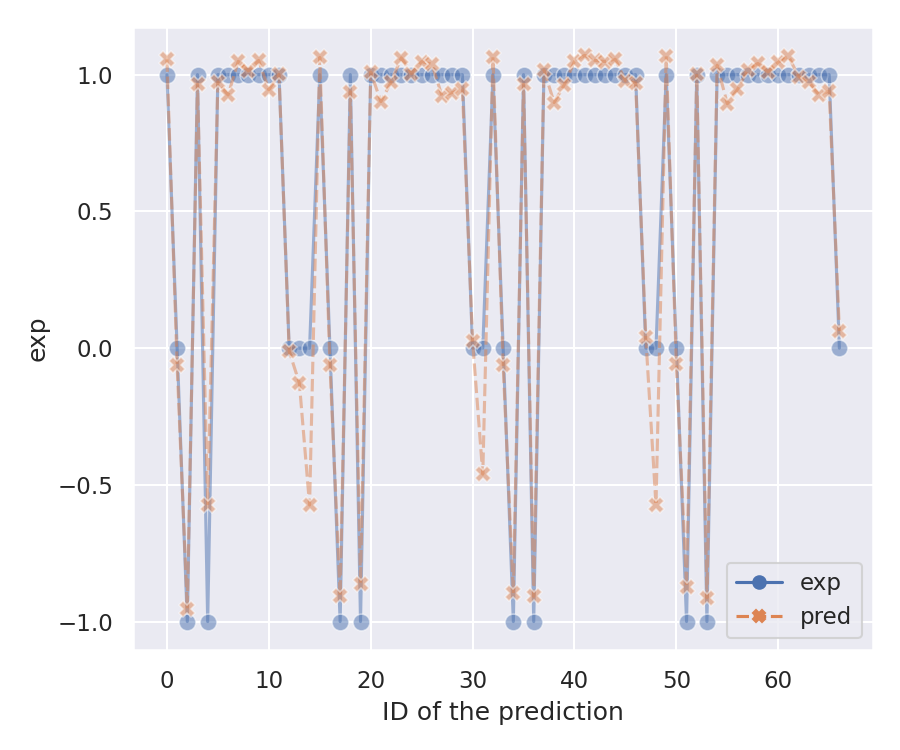

In [54]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

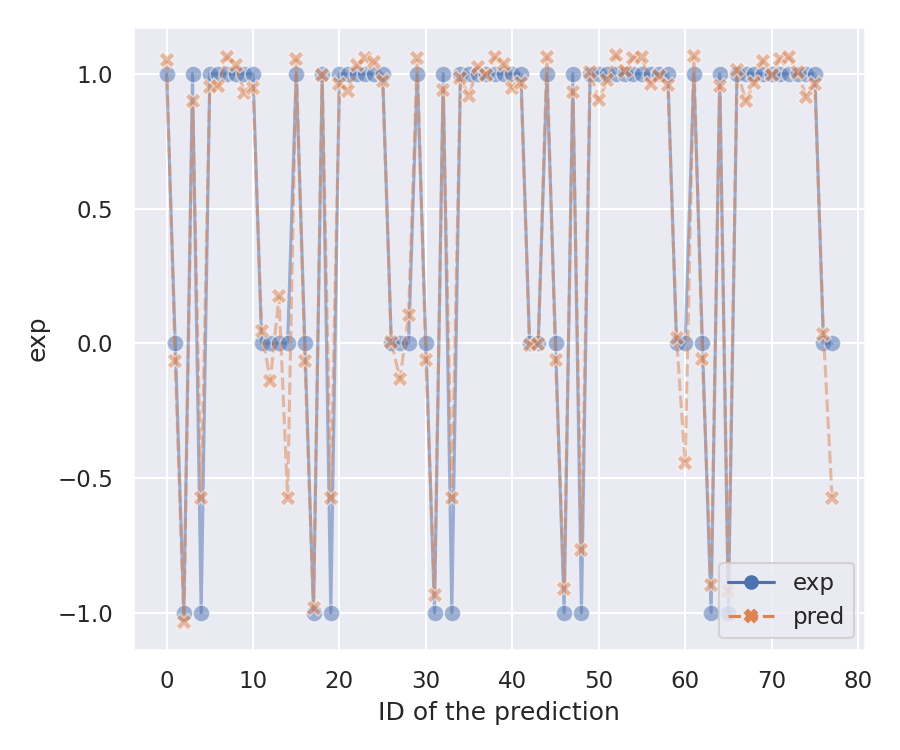

In [55]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

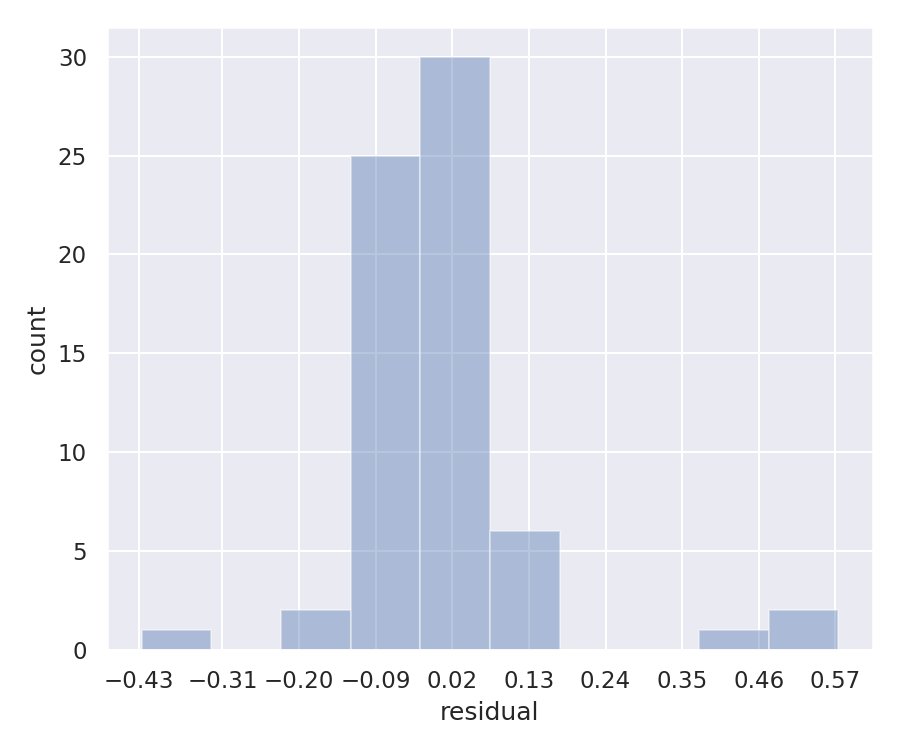

In [56]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

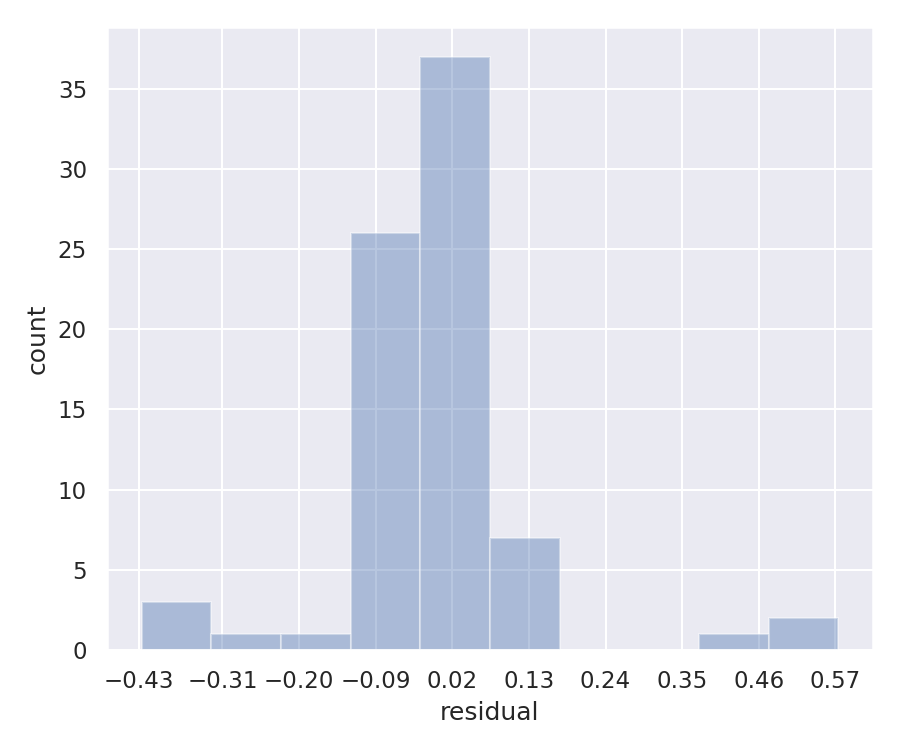

In [57]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

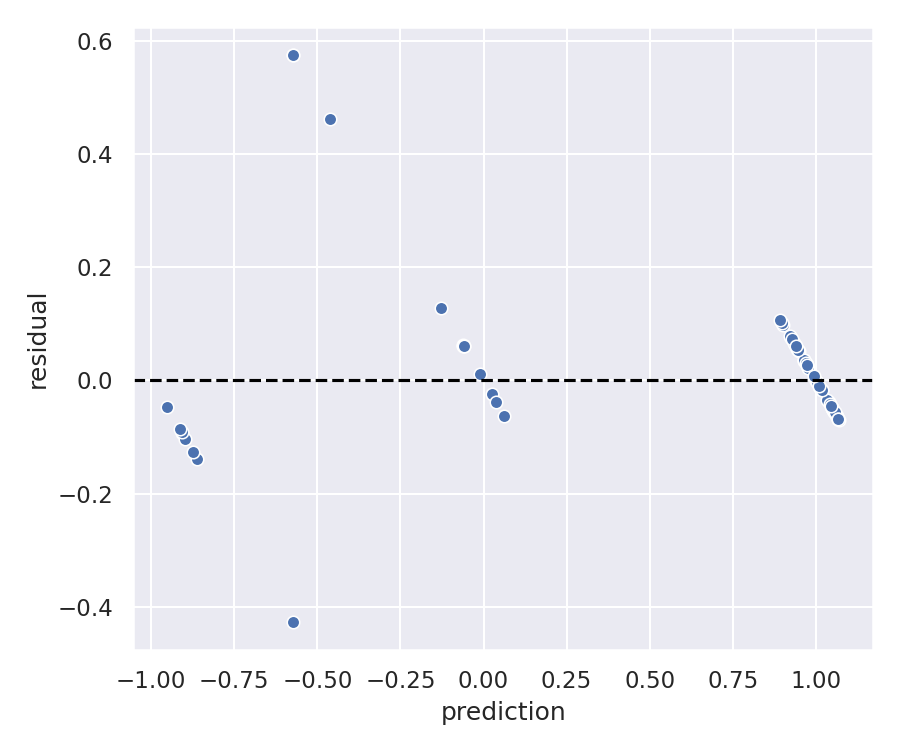

In [58]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

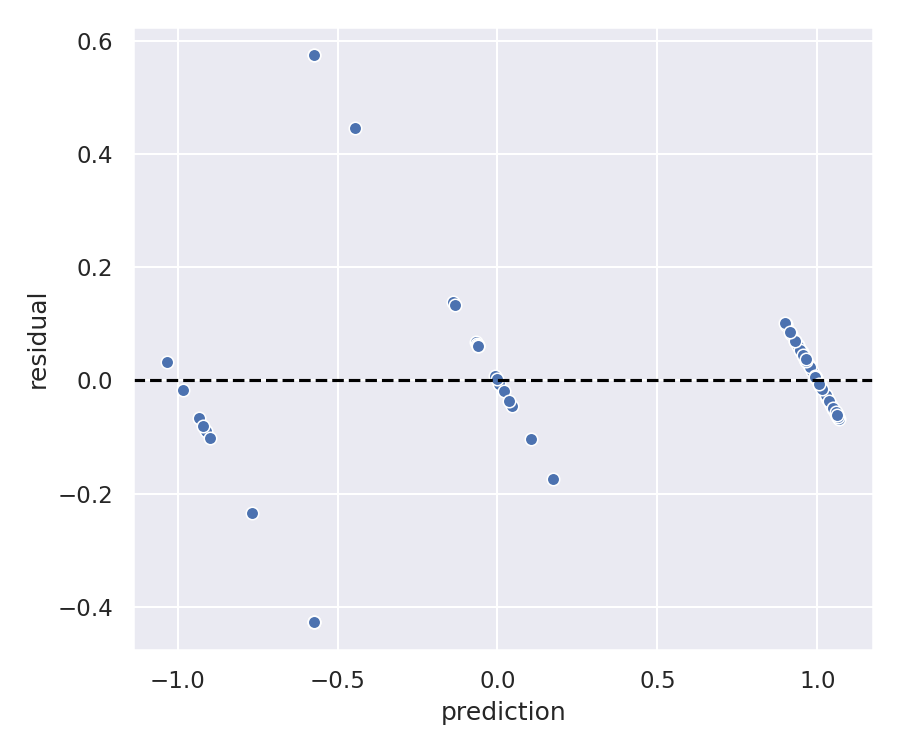

In [59]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [60]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = name + '_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.001 seconds.
Trained ratio 0.20 in 0.002 seconds.
Trained ratio 0.30 in 0.005 seconds.
Trained ratio 0.40 in 0.008 seconds.
Trained ratio 0.50 in 0.020 seconds.
Trained ratio 0.60 in 0.021 seconds.
Trained ratio 0.70 in 0.027 seconds.
Trained ratio 0.80 in 0.031 seconds.
Trained ratio 0.90 in 0.040 seconds.
Learning curve for SVR trained in 0.231 seconds.


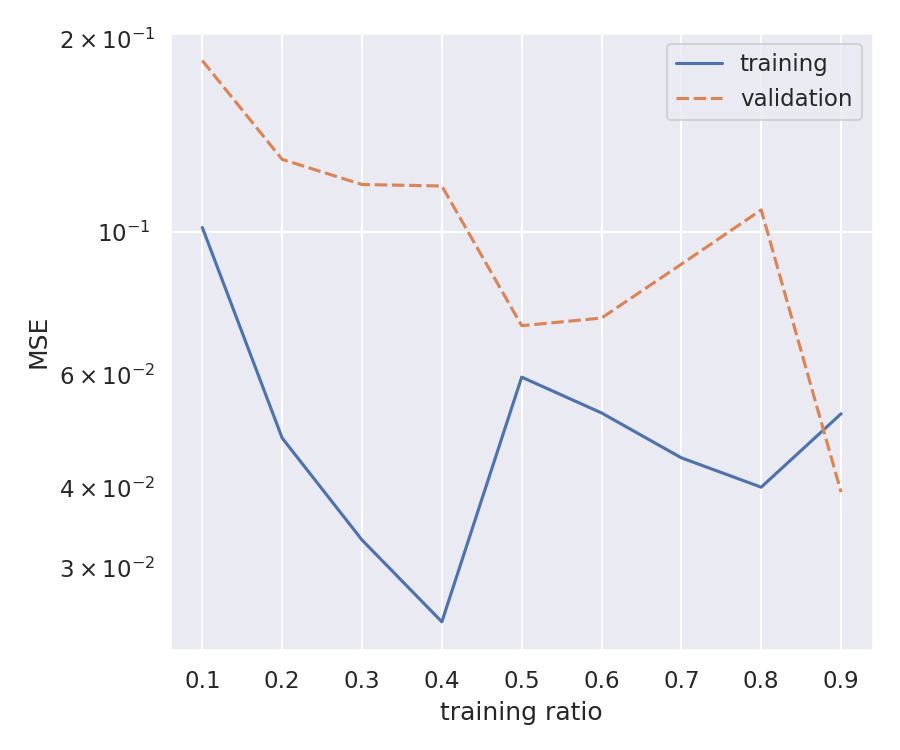

In [61]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Random Forests

We then move to the decision trees and in particular to the ensemble learning technique of _random forests_.

In [114]:
from lightgbm import LGBMRegressor
import joblib

# choose the estimator
estimator = LGBMRegressor(boosting_type = 'rf',
                          objective = 'regression',
                          subsample_freq = 1,
                          n_jobs = -1,
                          importance_type='gain'
                         )

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/rf_{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/rf_lgbmregressor.pkl']

We then define the hyperparameters for the optimisation:

In [115]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Integer(2, 200, name='num_leaves'),
          Integer(50, 500, name='max_depth'),
          Integer(2, 50, name='n_estimators'),
          Real(0.1, 0.99, name='subsample'),
          Real(0.7, 1.0, name='colsample_bytree'),
          Real(1.0e-6, 1.0e-2,
               prior='log-uniform',
               name='min_child_weight'
              ),
          Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_alpha'),
          Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_lambda')
         ]

# save the parameters
PARAMS = './models/rf_{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/rf_lgbmregressor_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [116]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

LGBMRegressor optimised in 52.994 seconds.
LGBMRegressor trained in 0.163 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [117]:
import pandas as pd

!mv ./hypers/lgbmregressor.csv ./hypers/rndfor.csv
pd.read_csv('./hypers/rndfor.csv'.format(name))

,names,values
0,num_leaves,70.000000
1,max_depth,500.000000
2,n_estimators,50.000000
3,subsample,0.990000
4,colsample_bytree,1.000000
5,min_child_weight,0.000001
6,reg_alpha,0.100000
7,reg_lambda,0.123078


The trained estimator is therefore:

In [118]:
import joblib

joblib.load(ESTIMATOR)

LGBMRegressor(boosting_type='rf', importance_type='gain', max_depth=500,
              min_child_weight=1e-06, n_estimators=50, num_leaves=70,
              objective='regression', reg_alpha=0.1,
              reg_lambda=0.12307761203933984, subsample=0.99, subsample_freq=1)

After training, we then compute the predictions and the metrics:

In [119]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.003 seconds.
LGBMRegressor predicted in 0.003 seconds.


In [120]:
import json

!mv ./metrics/lgbmregressor_train.json ./metrics/rf_lgbmregressor_train.json
with open('./metrics/rf_{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
!mv ./metrics/lgbmregressor_val.json ./metrics/rf_lgbmregressor_val.json
with open('./metrics/rf_{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
!mv ./metrics/lgbmregressor_test.json ./metrics/rf_lgbmregressor_test.json    
with open('./metrics/rf_{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lgbmregressor_train,554,0.023632,0.012571,0.034694,0.153728,0.042902,0.952700
lgbmregressor_val,48,0.003536,-0.000040,0.007112,0.059466,0.024297,0.992664
lgbmregressor_test,59,0.011051,-0.002755,0.024857,0.105124,0.036618,0.978171


Finally we produce all the necessary plots and display them:

In [121]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'rf_' + name + '_val'
OUTPUT_TEST = 'rf_' + name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

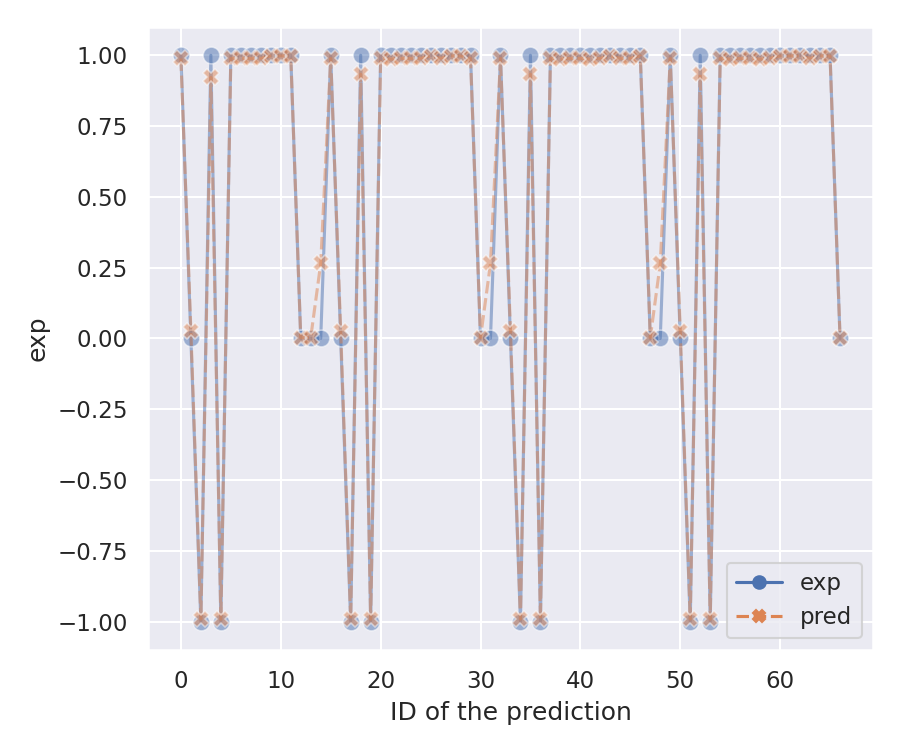

In [122]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

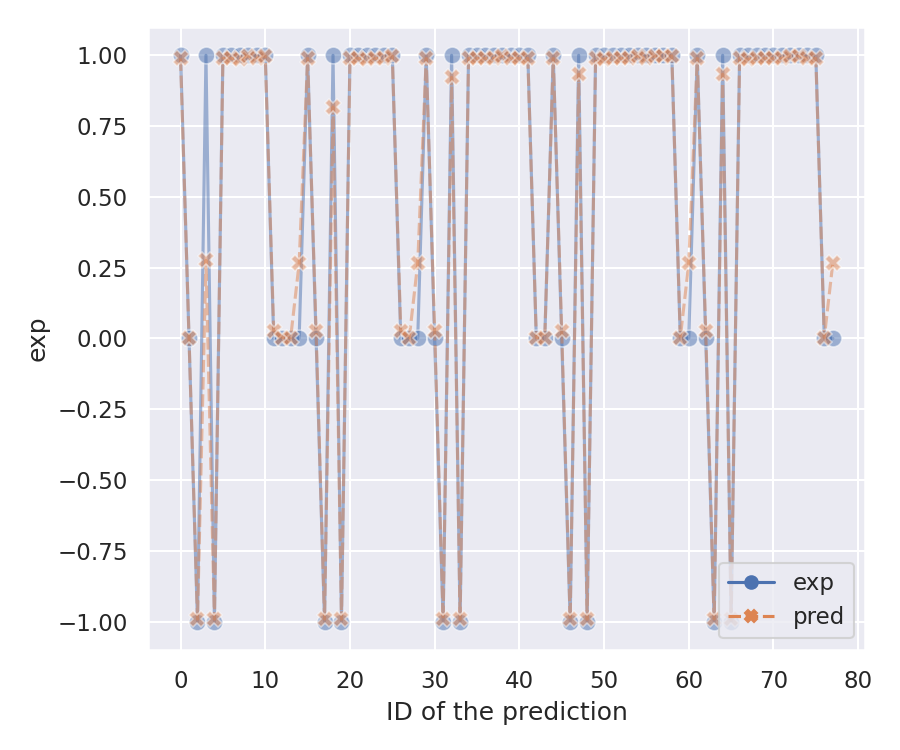

In [123]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

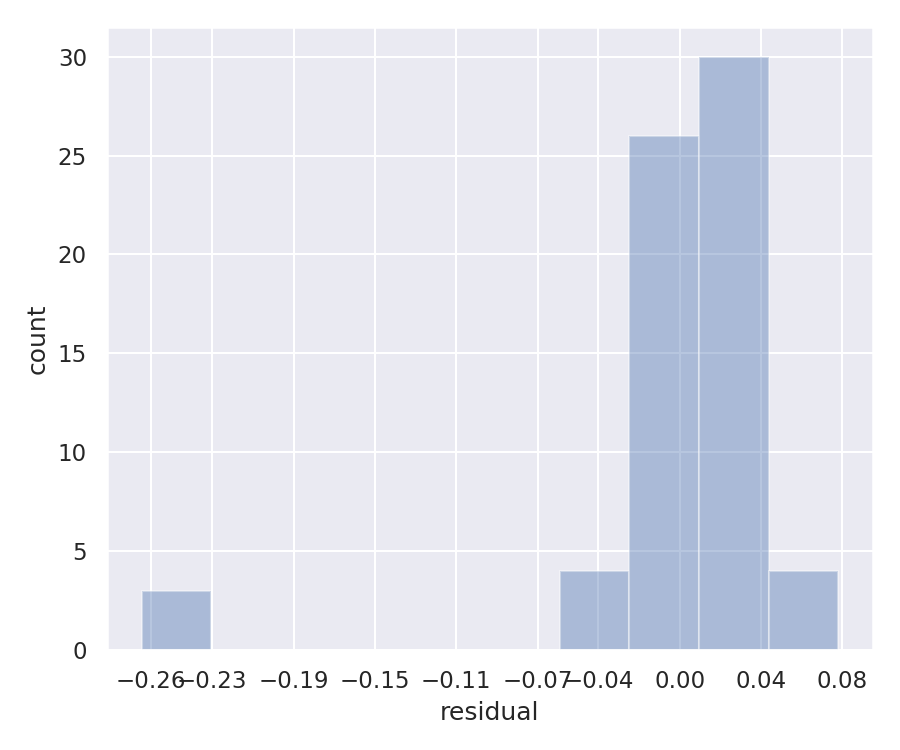

In [124]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

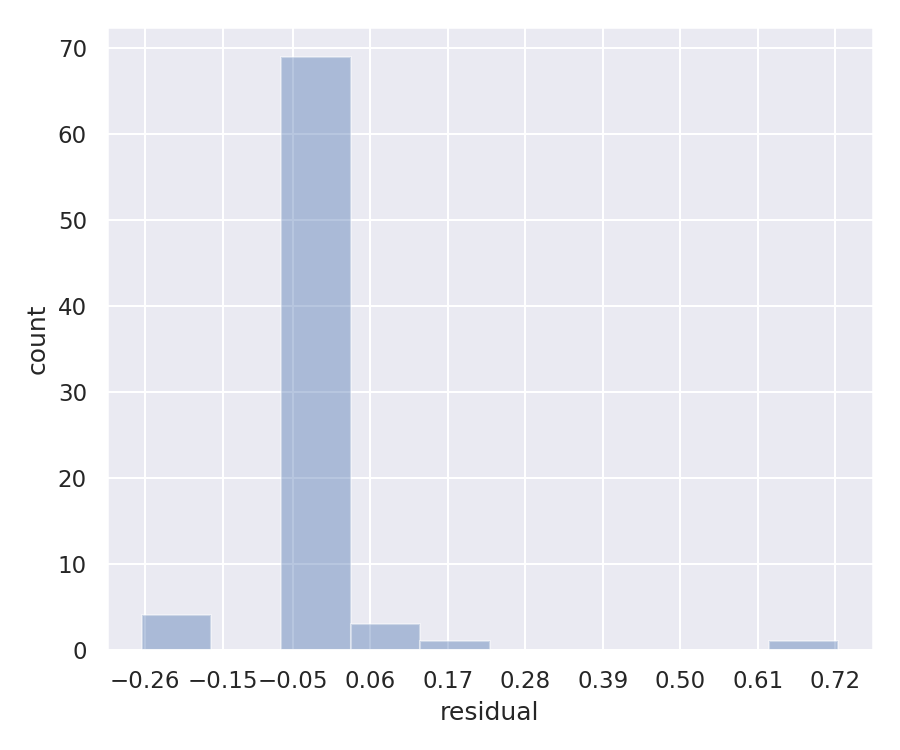

In [125]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

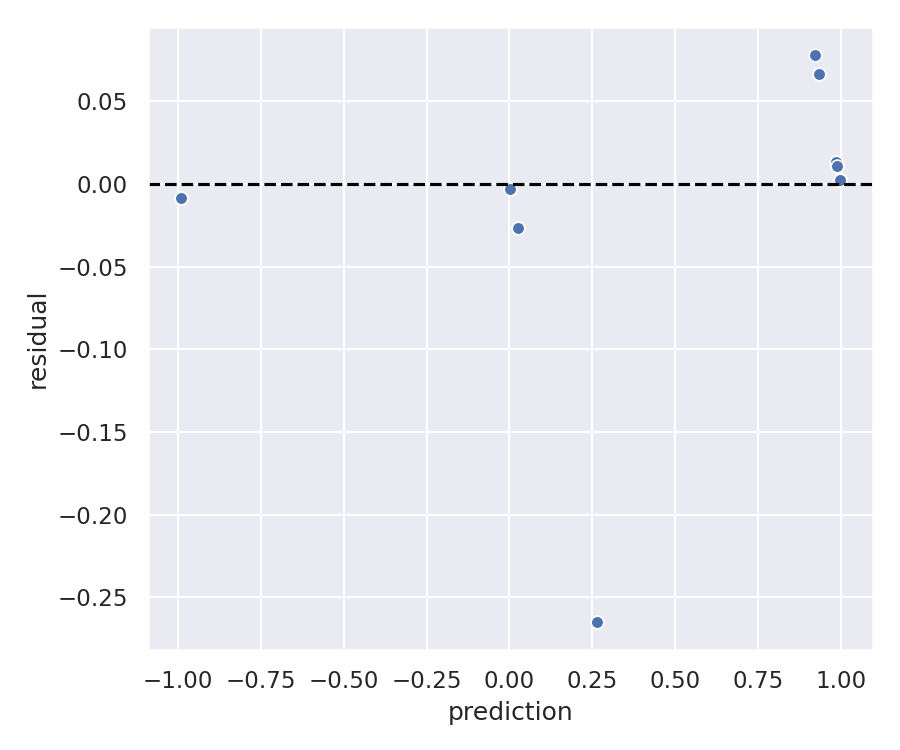

In [126]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

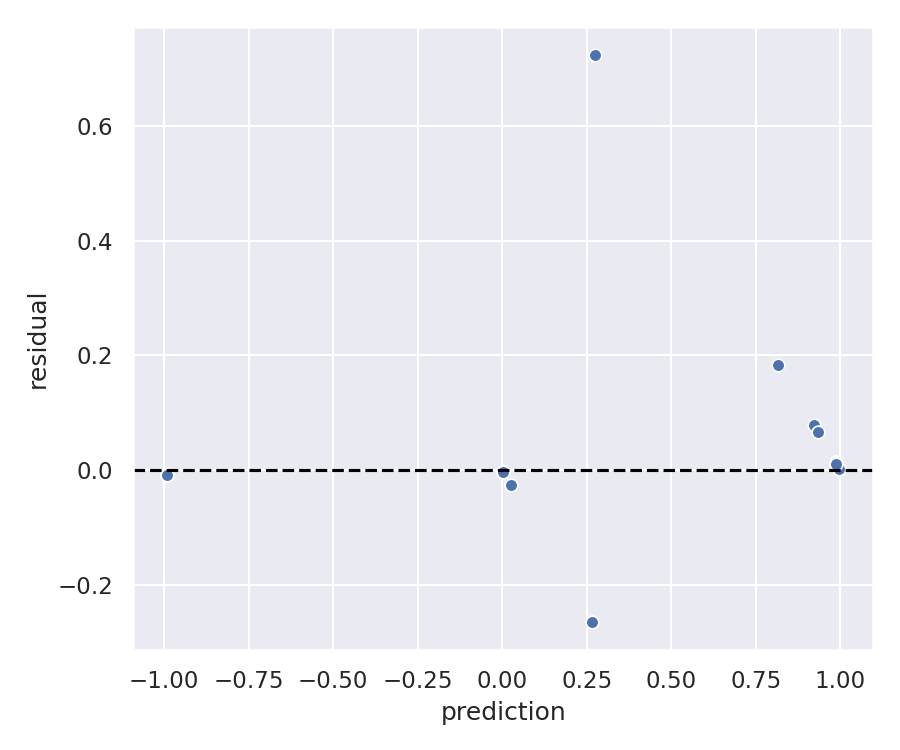

In [127]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [128]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'rf_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.012 seconds.
Trained ratio 0.20 in 0.011 seconds.
Trained ratio 0.30 in 0.014 seconds.
Trained ratio 0.40 in 0.018 seconds.
Trained ratio 0.50 in 0.028 seconds.
Trained ratio 0.60 in 0.036 seconds.
Trained ratio 0.70 in 0.026 seconds.
Trained ratio 0.80 in 0.026 seconds.
Trained ratio 0.90 in 0.028 seconds.
Learning curve for LGBMRegressor trained in 0.239 seconds.


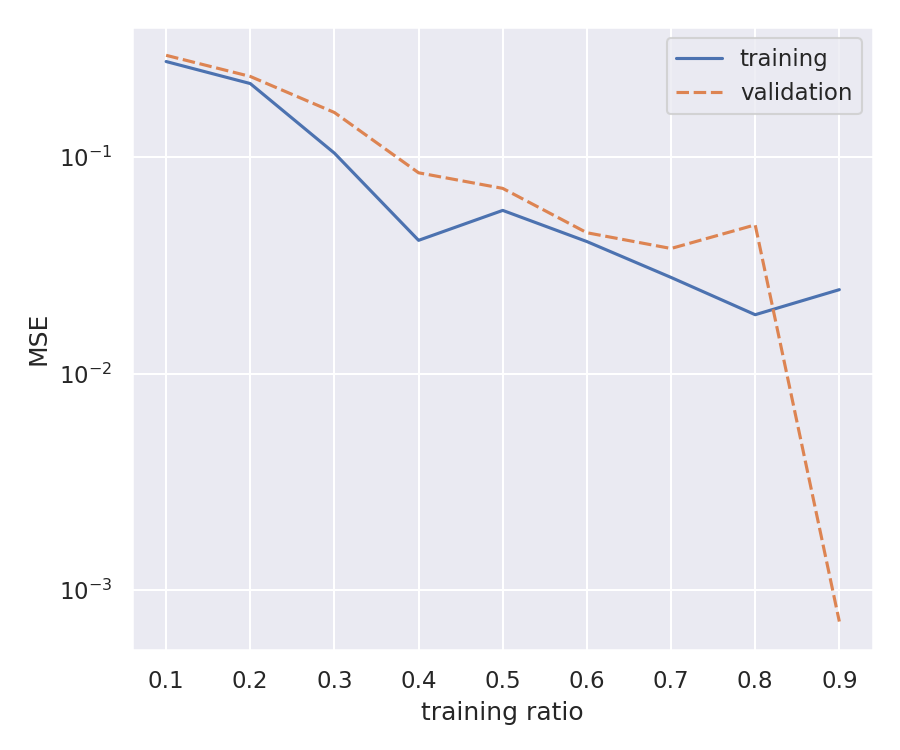

In [129]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Gradient Boosting

We consider another ensemble technique based on decision trees: gradient boosting.

In [130]:
from lightgbm import LGBMRegressor
import joblib

# choose the estimator
estimator = LGBMRegressor(boosting_type = 'gbdt',
                          objective = 'regression',
                          subsample_freq = 1,
                          n_jobs = 1,
                          importance_type='gain'
                         )

# save the estimator
name = estimator.__class__.__name__.lower()

ESTIMATOR = './models/gbdt_{}.pkl'.format(name)
joblib.dump(estimator, ESTIMATOR)

['./models/gbdt_lgbmregressor.pkl']

We then define the hyperparameters for the optimisation:

In [131]:
from skopt.space import Categorical, Integer, Real

# set hyperparameters
params = [Integer(2, 25, name='num_leaves'),
          Integer(2, 25, name='max_depth'),
          Real(1e-3, 1e-1, prior='log-uniform', name='learning_rate'),
          Integer(1e1, 4e3, prior='log-uniform', name='n_estimators'),
          Real(0.1, 0.99, name='subsample'),
          Real(0.7, 1.0, name='colsample_bytree'),
          Real(1.0e-3, 1.0e-1, prior='log-uniform', name='min_child_weight'),
          Real(1.0e0, 1.0e2, prior='log-uniform', name='reg_alpha'),
          Real(1.0e0, 1.0e3, prior='log-uniform', name='reg_lambda')
         ]
# save the parameters
PARAMS = './models/gbdt_{}_space.pkl'.format(name)
joblib.dump(params, PARAMS)

['./models/gbdt_lgbmregressor_space.pkl']

Finally we can run the Bayes optimisation procedure:

In [132]:
CALLS = 100

!python3 ./scripts/scikit-optim.py -t {TRAIN} -v {VAL} \
                                   -lt {LAB_TRAIN} -lv {LAB_VAL} \
                                   -e {ESTIMATOR} \
                                   -p {PARAMS} -n {CALLS} -r {RAND}

LGBMRegressor optimised in 96.111 seconds.
LGBMRegressor trained in 0.321 seconds.


After the optimisation (and training over the training set with the best hyperparameters) we can display the best hyperparameters chosen by the optimisation procedure:

In [133]:
import pandas as pd

!mv ./hypers/lgbmregressor.csv ./hypers/grdbst.csv
pd.read_csv('./hypers/grdbst.csv'.format(name))

,names,values
0,num_leaves,25.000000
1,max_depth,25.000000
2,learning_rate,0.100000
3,n_estimators,4000.000000
4,subsample,0.740544
5,colsample_bytree,0.823415
6,min_child_weight,0.006557
7,reg_alpha,1.000000
8,reg_lambda,1.000000


The trained estimator is therefore:

In [134]:
import joblib

joblib.load(ESTIMATOR)

LGBMRegressor(colsample_bytree=0.8234150651022168, importance_type='gain',
              max_depth=25, min_child_weight=0.006557315696637153,
              n_estimators=4000, n_jobs=1, num_leaves=25,
              objective='regression', reg_alpha=1.0, reg_lambda=1.0,
              subsample=0.7405440640654122, subsample_freq=1)

After training, we then compute the predictions and the metrics:

In [135]:
OUTPUT_TRAIN = name + '_train'
OUTPUT_VAL   = name + '_val'
OUTPUT_TEST  = name + '_test'

!python3 ./scripts/scikit-predict.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR} -o {OUTPUT_TRAIN}
!python3 ./scripts/scikit-predict.py -t {VAL} -l {LAB_VAL} -e {ESTIMATOR} -o {OUTPUT_VAL}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT_TEST}

LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.002 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [136]:
import json

!mv ./metrics/lgbmregressor_train.json ./metrics/gbdt_lgbmregressor_train.json
with open('./metrics/gbdt_{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
!mv ./metrics/lgbmregressor_val.json ./metrics/gbdt_lgbmregressor_val.json    
with open('./metrics/gbdt_{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
!mv ./metrics/lgbmregressor_test.json ./metrics/gbdt_lgbmregressor_test.json    
with open('./metrics/gbdt_{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lgbmregressor_train,554,0.004797,0.002203,0.007391,0.069262,0.023315,0.990398
lgbmregressor_val,48,0.000211,0.000115,0.000306,0.014523,0.009598,0.999563
lgbmregressor_test,59,0.001177,0.000309,0.002046,0.034310,0.017302,0.997675


Finally we produce all the necessary plots and display them:

In [137]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'gbdt_' + name + '_val'
OUTPUT_TEST = 'gbdt_' + name + '_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

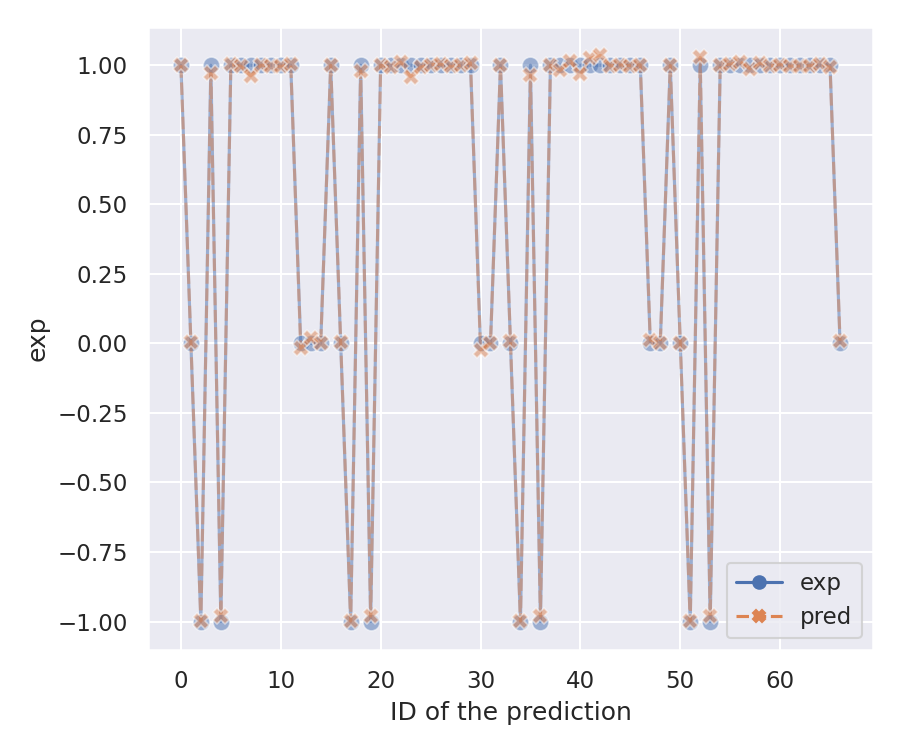

In [138]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

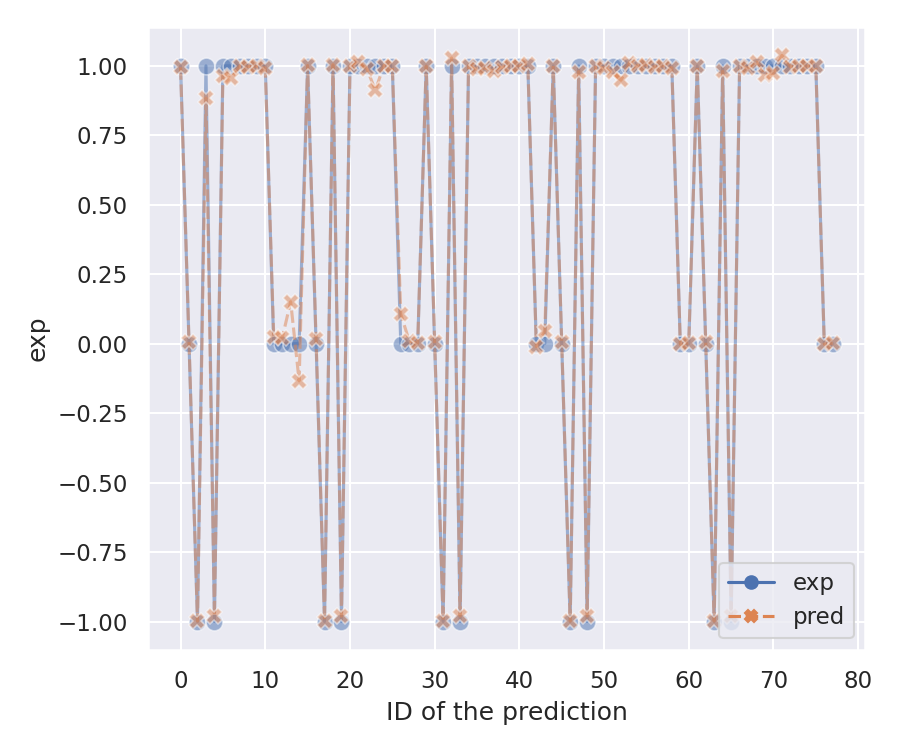

In [139]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

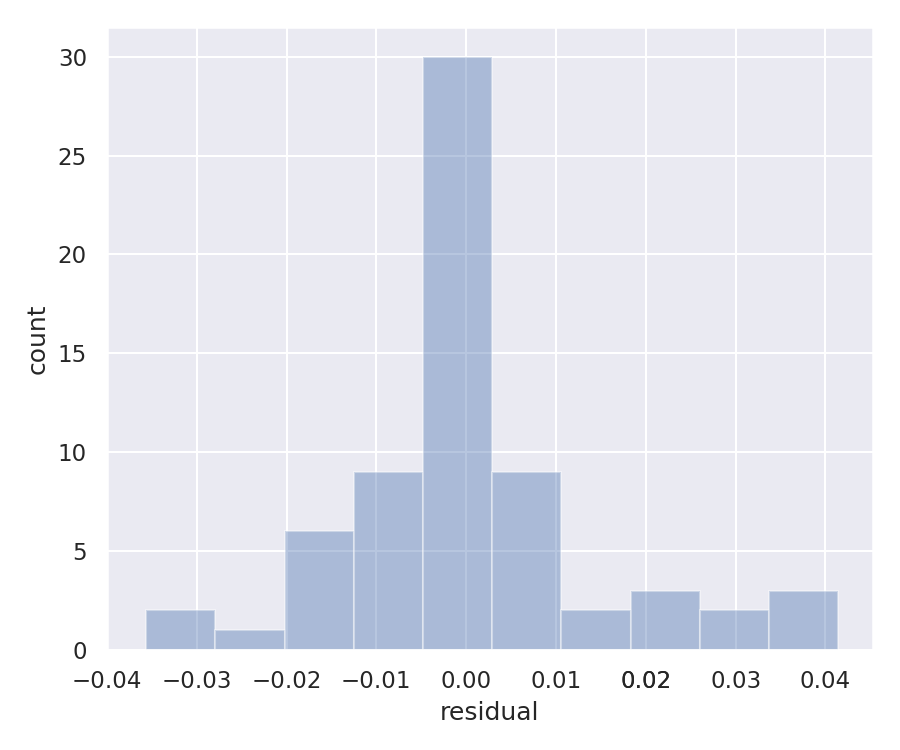

In [140]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

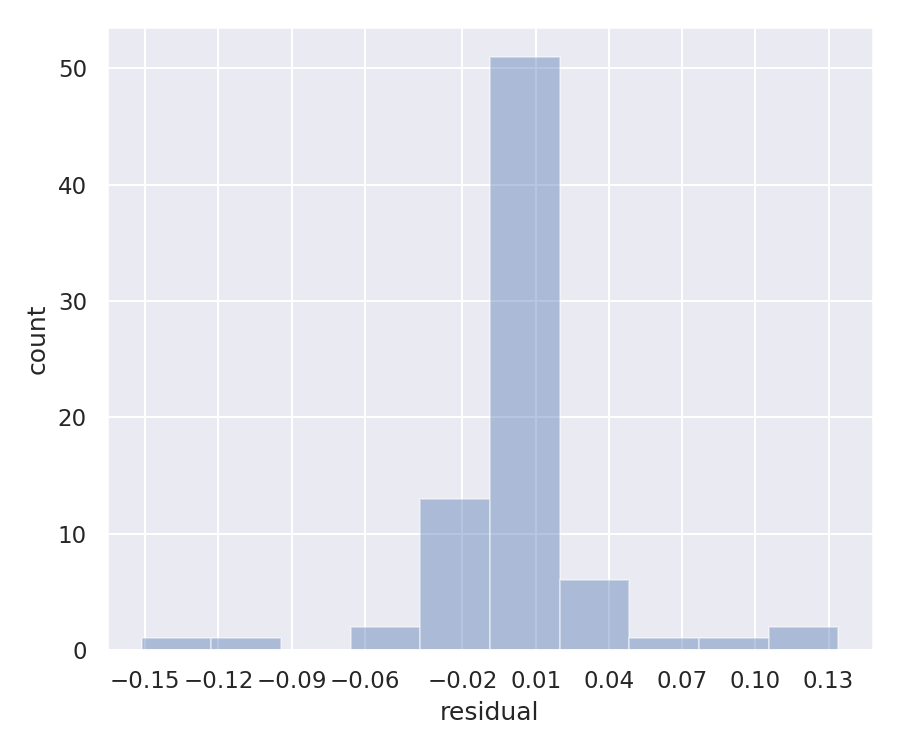

In [141]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

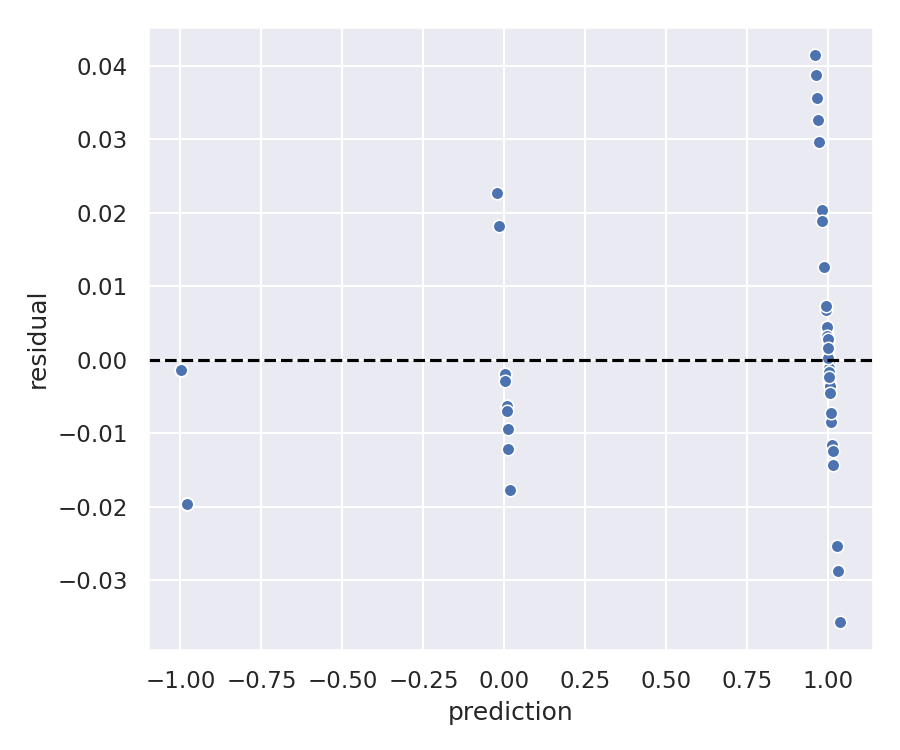

In [142]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

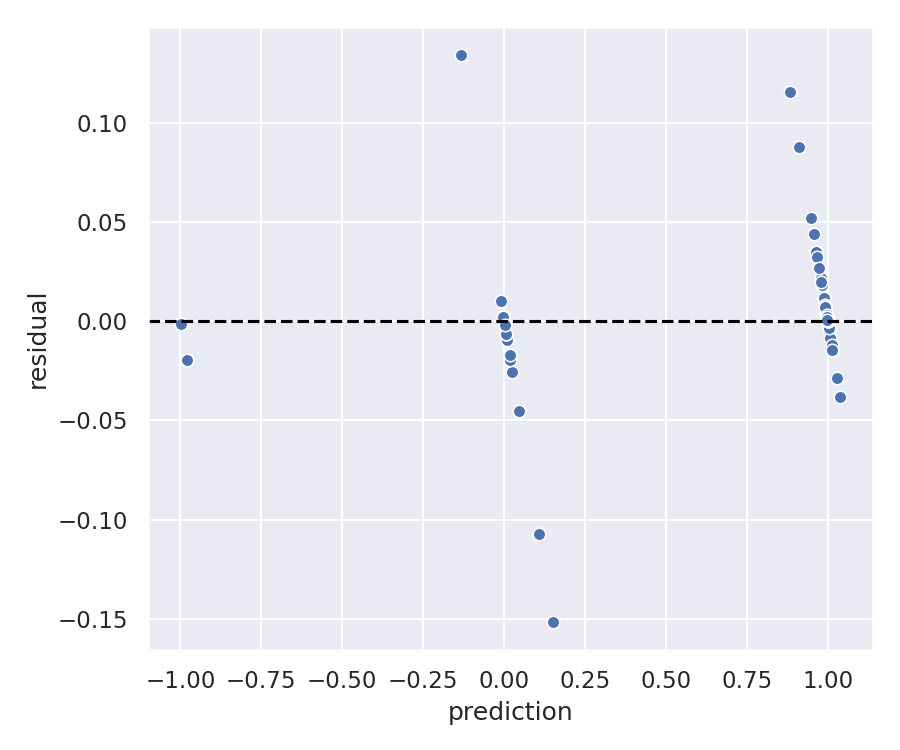

In [143]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

We finally take a look at the learning curve:

In [144]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'gbdt_lc'

!python3 ./scripts/scikit-lc.py --data {DATA} --estimator {ESTIMATOR} --rand {RAND} --output {OUTPUT}

Trained ratio 0.10 in 0.059 seconds.
Trained ratio 0.20 in 0.092 seconds.
Trained ratio 0.30 in 0.128 seconds.
Trained ratio 0.40 in 0.157 seconds.
Trained ratio 0.50 in 0.192 seconds.
Trained ratio 0.60 in 0.219 seconds.
Trained ratio 0.70 in 0.252 seconds.
Trained ratio 0.80 in 0.282 seconds.
Trained ratio 0.90 in 0.320 seconds.
Learning curve for LGBMRegressor trained in 1.767 seconds.


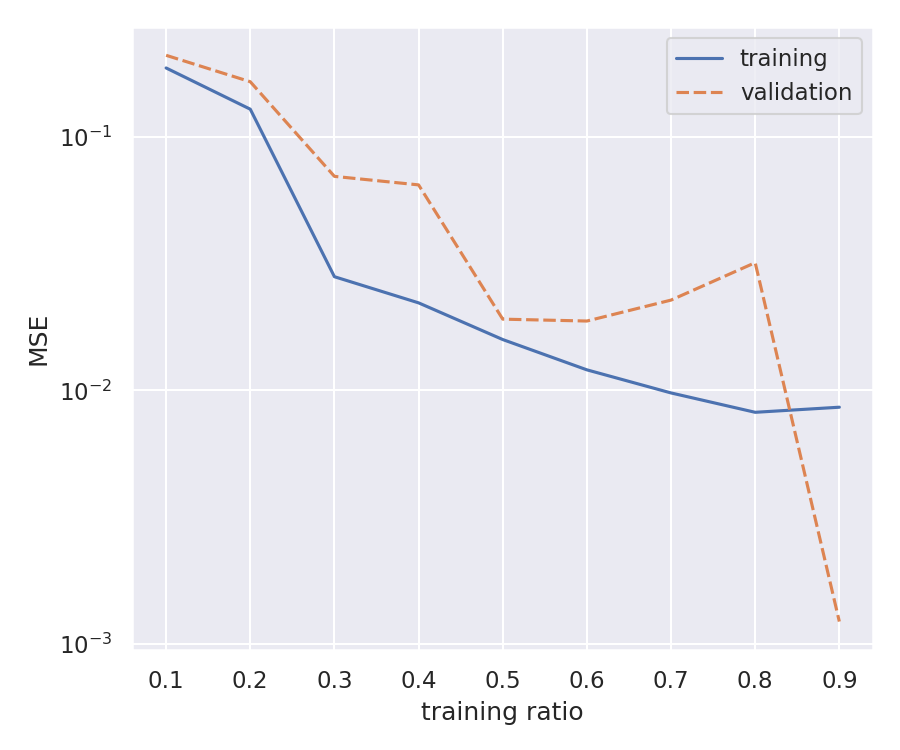

In [145]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Artificial Neural Networks

As a final model we use a simple fully connected (FC) ANN to predict the labels. We first build the model (it should not be too complicated, thus we can actually use the `Sequential` interface in `tf.keras`).

In [94]:
input_shape=(19,)

In [95]:
from tensorflow       import keras
from tensorflow.keras import layers, \
                             initializers, \
                             optimizers, \
                             regularizers, \
                             losses, \
                             metrics
from sklearn.metrics  import mean_squared_error, \
                             mean_absolute_error, \
                             r2_score


from tensorflow.keras.models import save_model

# clear leftover sessions
keras.backend.clear_session()

# build shortcuts to include layers
inputer  = lambda n: layers.Dense(n,
                         input_shape=input_shape,
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.20)
                        )
denser   = lambda n: layers.Dense(n,
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )
dropper  = lambda x: layers.Dropout(rate=x, seed=RAND)
outputer = lambda n: layers.Dense(n,
                         name='output',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )

# build the model
ann_mod = keras.Sequential(name='sft-trunc')

ann_mod.add(inputer(30))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.005))

ann_mod.add(denser(20))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.005))

ann_mod.add(denser(20))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.005))

ann_mod.add(denser(10))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.005))

ann_mod.add(outputer(1))

# compile the model
ann_mod.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss=losses.MeanSquaredError(),
                metrics=[metrics.MeanSquaredError()]
               )

ann_mod.summary()

# save the model
ANN_MODEL = './models/ann.h5'
save_model(ann_mod, ANN_MODEL)

Model: "sft-trunc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                600       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                42

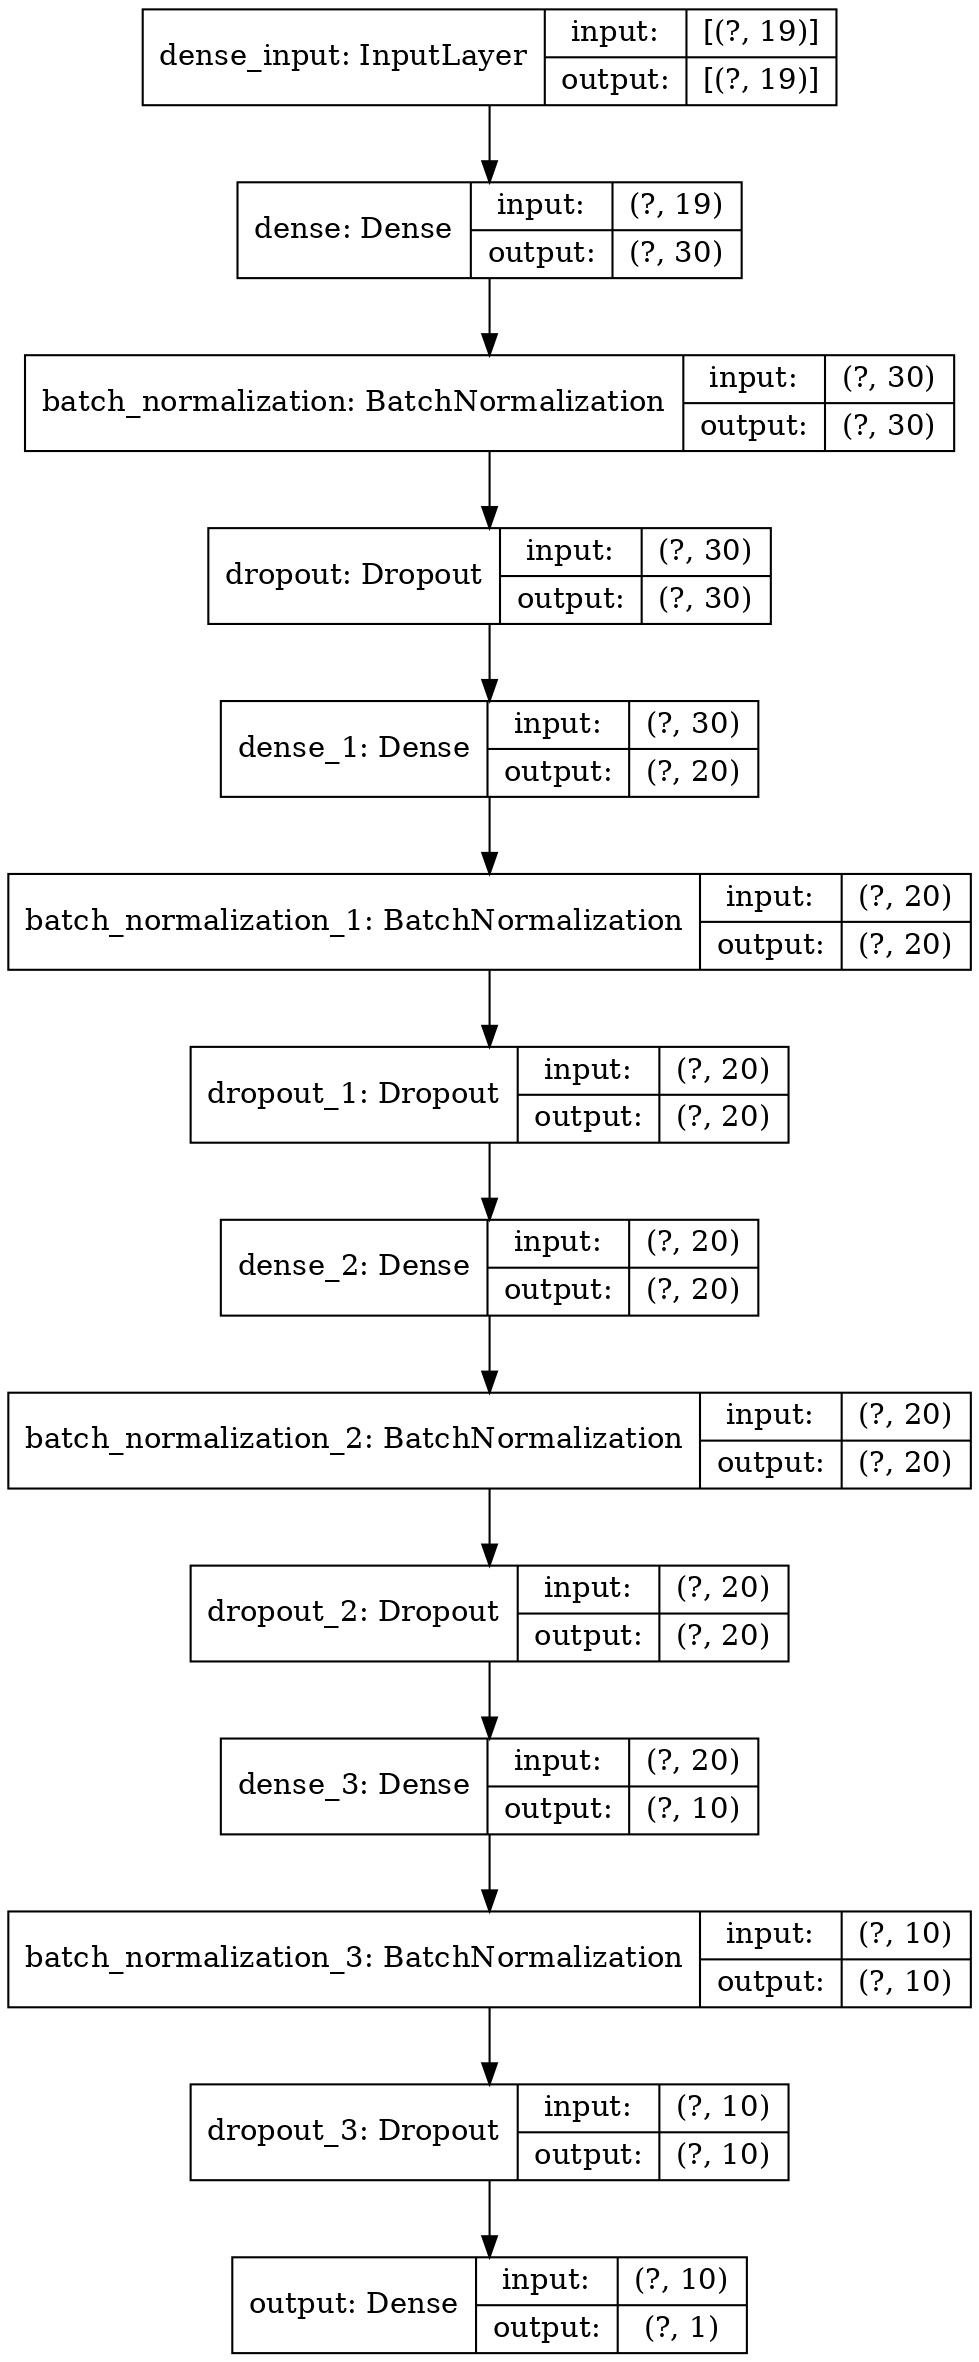

In [96]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

ann_mod_dot = model_to_dot(ann_mod, show_shapes=True, dpi=150)
ann_mod_dot.write_pdf('./img/ann_mod_arch.pdf')

Image(ann_mod_dot.create_png(), width=480)

We then fit the model on the data:

In [97]:
TRAIN = './data/train.csv'
VAL   = './data/val.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_VAL   = './data/lab_val.csv'

ANN_MODEL = './models/ann.h5'
EPOCHS    = 20000
BATCH     = 32

RAND = 123

!python3 ./scripts/keras-train.py -t {TRAIN} -lt {LAB_TRAIN} \
                                  -v {VAL} -lv {LAB_VAL} \
                                  -e {EPOCHS} -b {BATCH} \
                                  -m {ANN_MODEL} -r {RAND}

Model trained in 1594.387 seconds.


Finally we compute metrics and predictions:

In [98]:
TEST = './data/test.csv'
LAB_TEST = './data/lab_test.csv'

ANN_MODEL = './models/ann.h5'

OUTPUT_TRAIN = 'ann_model_train'
OUTPUT_VAL   = 'ann_model_val'
OUTPUT_TEST  = 'ann_model_test'

!python3 ./scripts/keras-predict.py -t {TRAIN} -l {LAB_TRAIN} -m {ANN_MODEL} -o {OUTPUT_TRAIN}
!python3 ./scripts/keras-predict.py -t {VAL} -l {LAB_VAL} -m {ANN_MODEL} -o {OUTPUT_VAL}
!python3 ./scripts/keras-predict.py -t {TEST} -l {LAB_TEST} -m {ANN_MODEL} -o {OUTPUT_TEST}

Model predicted in 0.276 seconds.
Model predicted in 0.266 seconds.
Model predicted in 0.260 seconds.


In [99]:
import json

with open('./metrics/{}.json'.format(OUTPUT_TRAIN, 'r')) as f:
    metrics_train = pd.DataFrame(json.load(f), index=[OUTPUT_TRAIN])
with open('./metrics/{}.json'.format(OUTPUT_VAL, 'r')) as f:
    metrics_val = pd.DataFrame(json.load(f), index=[OUTPUT_VAL])
with open('./metrics/{}.json'.format(OUTPUT_TEST, 'r')) as f:
    metrics_test = pd.DataFrame(json.load(f), index=[OUTPUT_TEST])
    
pd.concat([metrics_train, metrics_val, metrics_test])

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
ann_model_train,554,0.001236,-0.000038,0.002510,0.035156,0.008064,0.997526
ann_model_val,48,0.000032,0.000022,0.000042,0.005686,0.004584,0.999933
ann_model_test,59,0.000046,0.000023,0.000069,0.006802,0.005048,0.999909


Finally we produce all the necessary plots and display them:

In [100]:
PREDS_VAL  = './predictions/{}.csv'.format(OUTPUT_VAL)
PREDS_TEST = './predictions/{}.csv'.format(OUTPUT_TEST)

OUTPUT_VAL  = 'ann_model_val'
OUTPUT_TEST = 'ann_model_test'

!python3 ./scripts/summary.py --data {PREDS_VAL} --output {OUTPUT_VAL}
!python3 ./scripts/summary.py --data {PREDS_TEST} --output {OUTPUT_TEST}

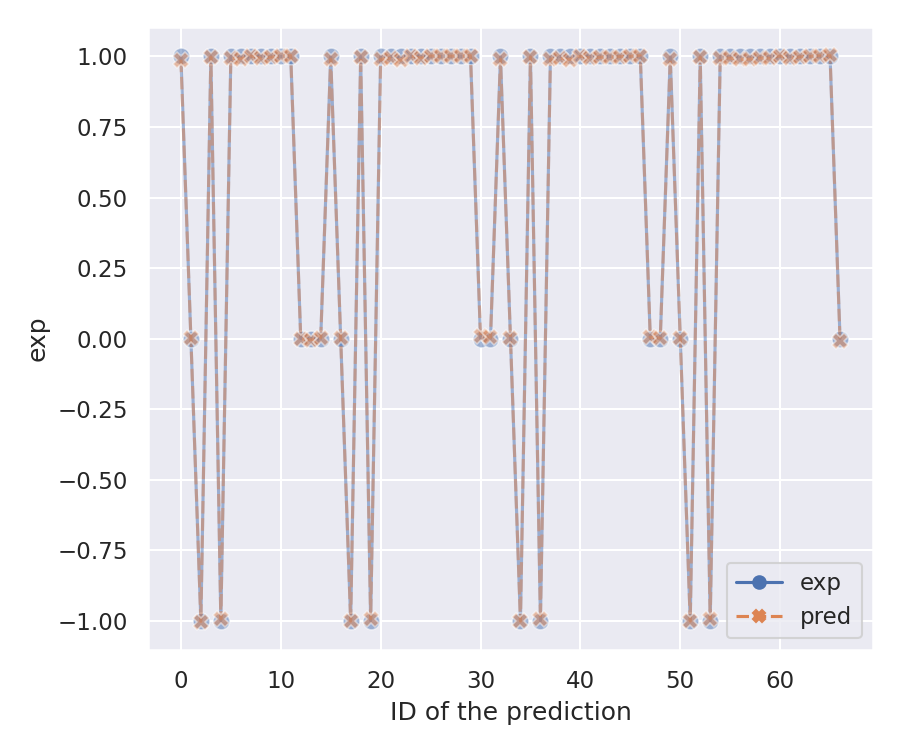

In [101]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_VAL), width=480)

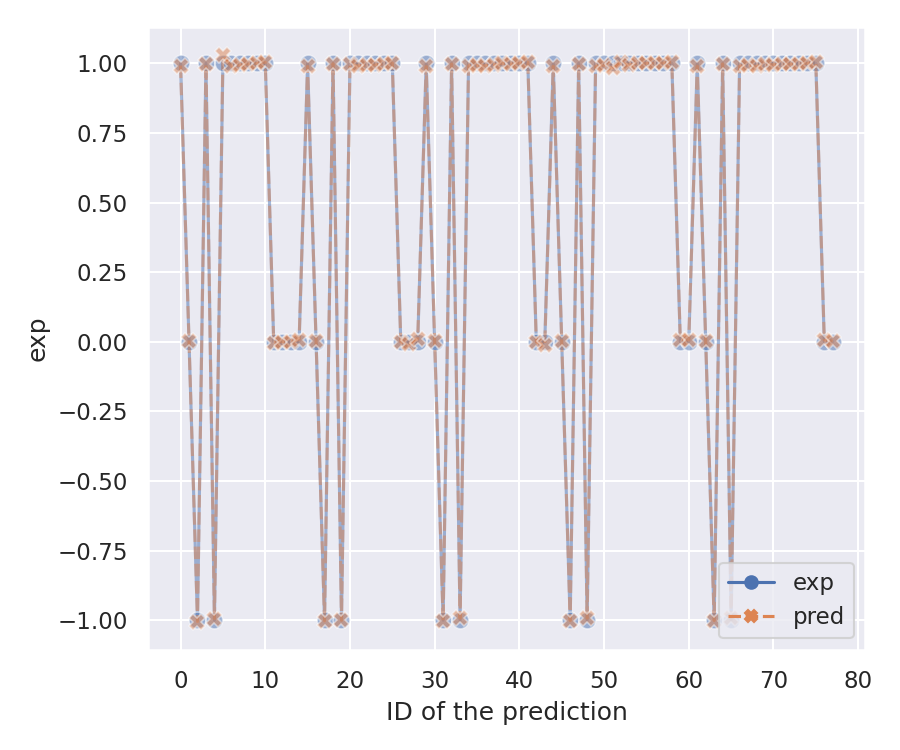

In [102]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT_TEST), width=480)

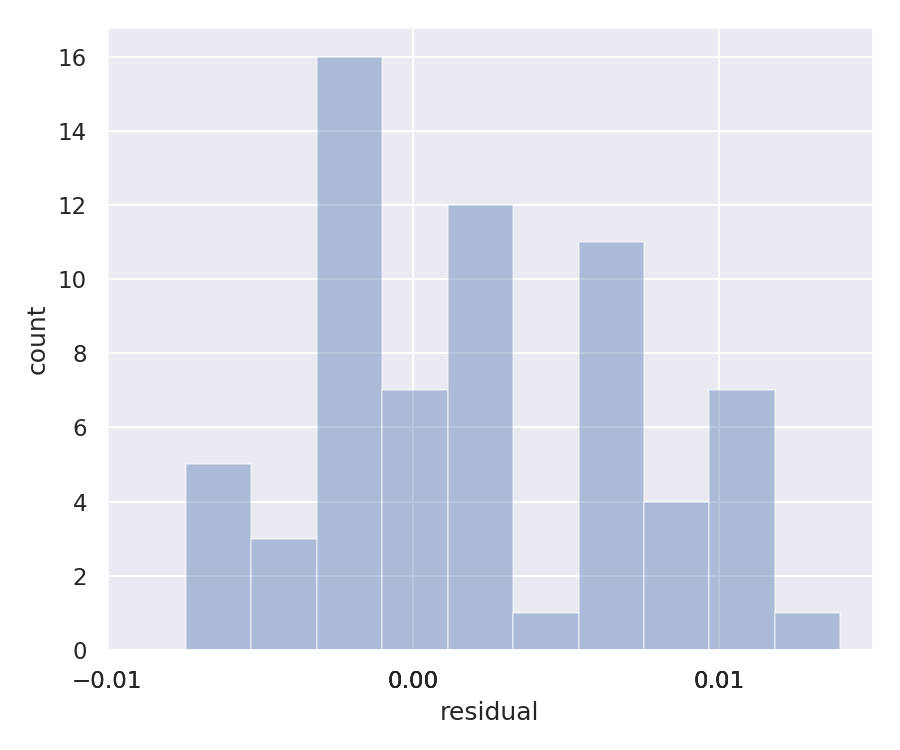

In [103]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_VAL), width=480)

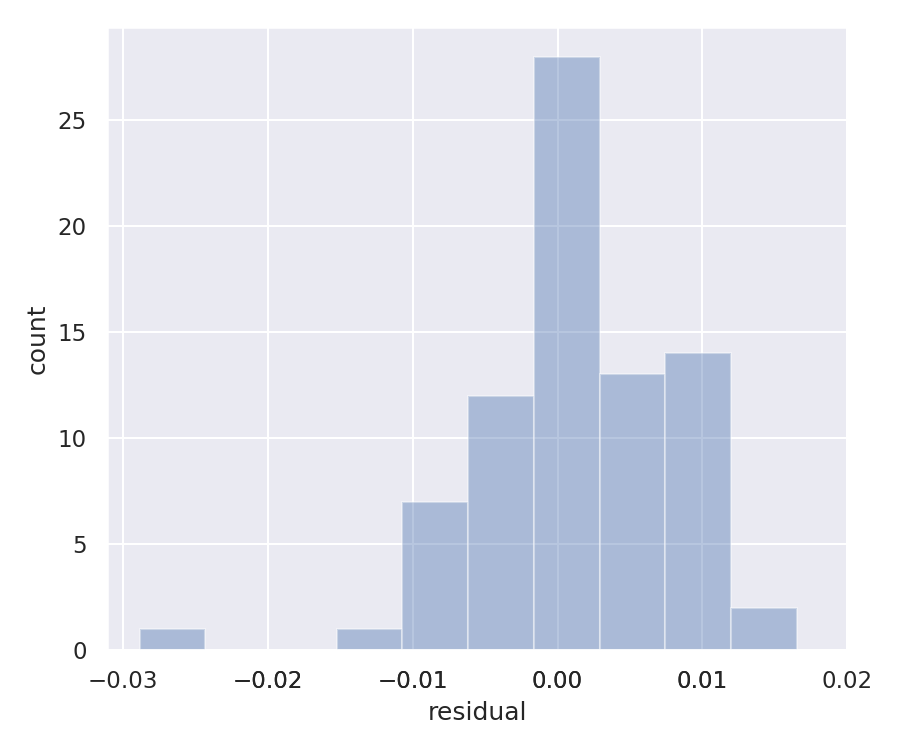

In [104]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT_TEST), width=480)

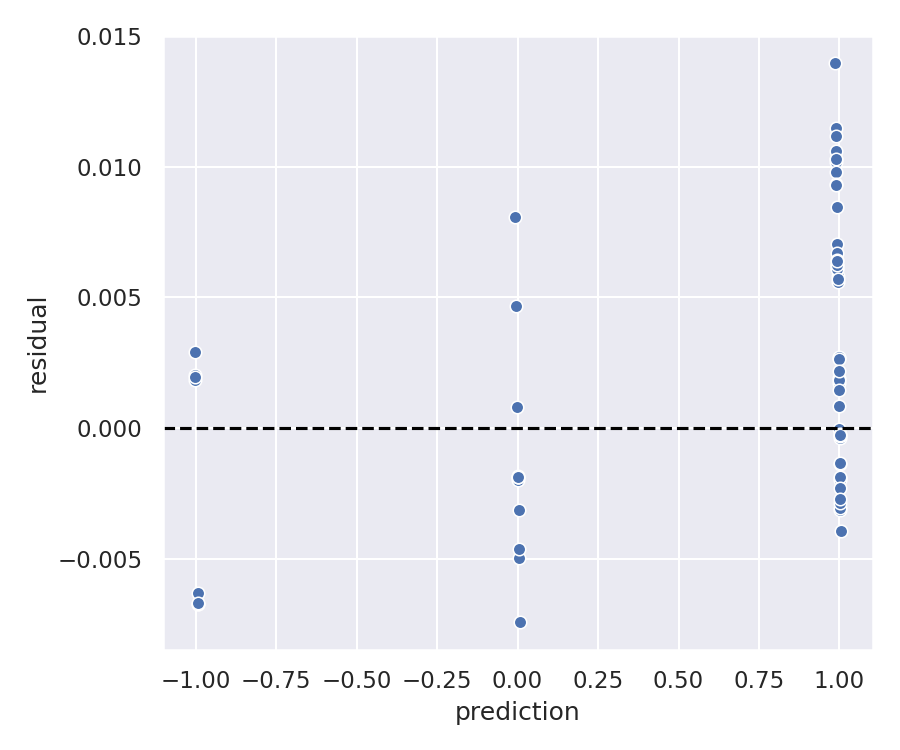

In [105]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_VAL), width=480)

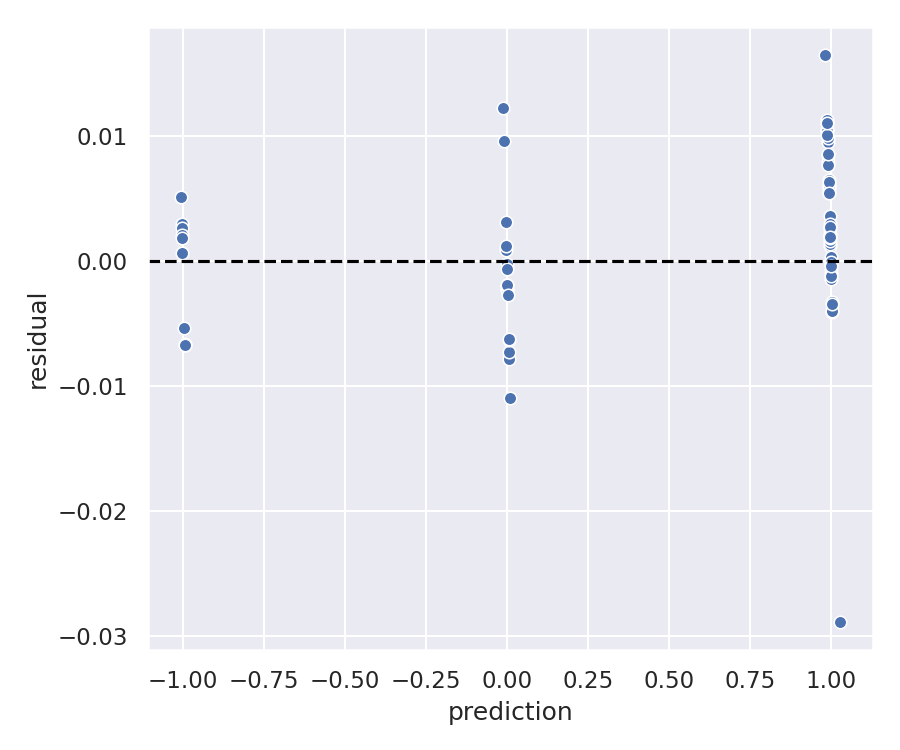

In [106]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT_TEST), width=480)

In [107]:
HISTORY = './models/ann_mod_hst.json'
OUTPUT  = 'ann_mod_hst'

!python3 ./scripts/keras-history.py --data {HISTORY} --output {OUTPUT}

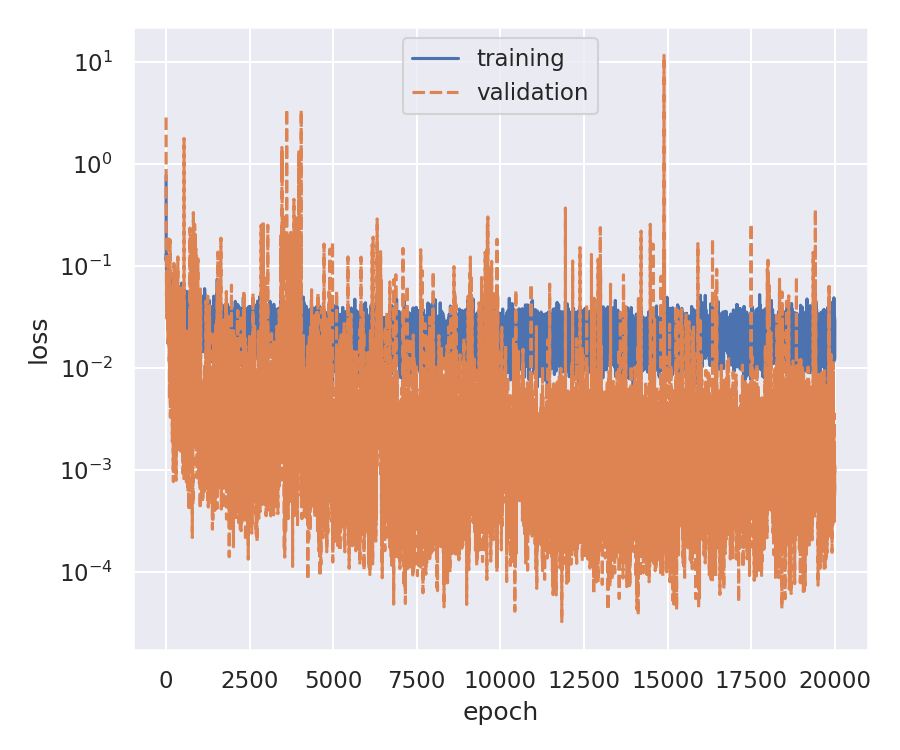

In [108]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

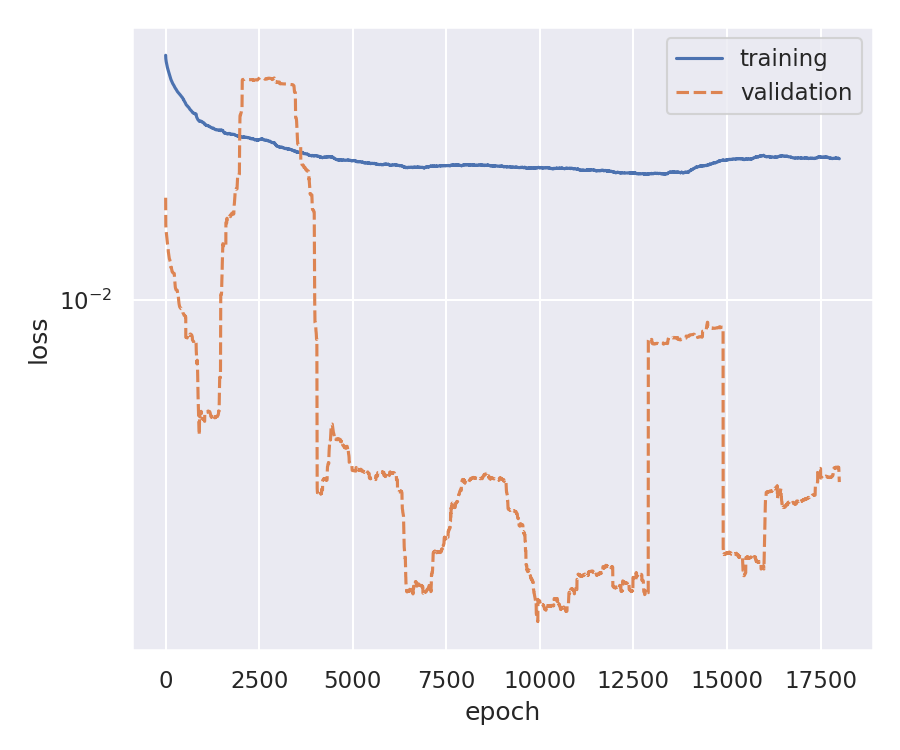

In [109]:
from IPython.display import Image
Image('./img/{}_avg.png'.format(OUTPUT), width=480)

We finally take a look at the learning curve:

In [110]:
DATA = './data/sft-trunc_eda.csv'
OUTPUT = 'ann_mod_lc'

!python3 ./scripts/keras-lc.py -d {DATA} -m {ANN_MODEL} -e {EPOCHS} -b {BATCH} -o {OUTPUT}

Trained ratio 0.10 in 1052.259 seconds.
Trained ratio 0.20 in 1140.714 seconds.
Trained ratio 0.30 in 1222.755 seconds.
Trained ratio 0.40 in 1333.879 seconds.
Trained ratio 0.50 in 1428.029 seconds.
Trained ratio 0.60 in 1504.030 seconds.
Trained ratio 0.70 in 1578.178 seconds.
Trained ratio 0.80 in 1614.527 seconds.
Trained ratio 0.90 in 1782.115 seconds.
Learning curve trained in 12658.935 seconds.


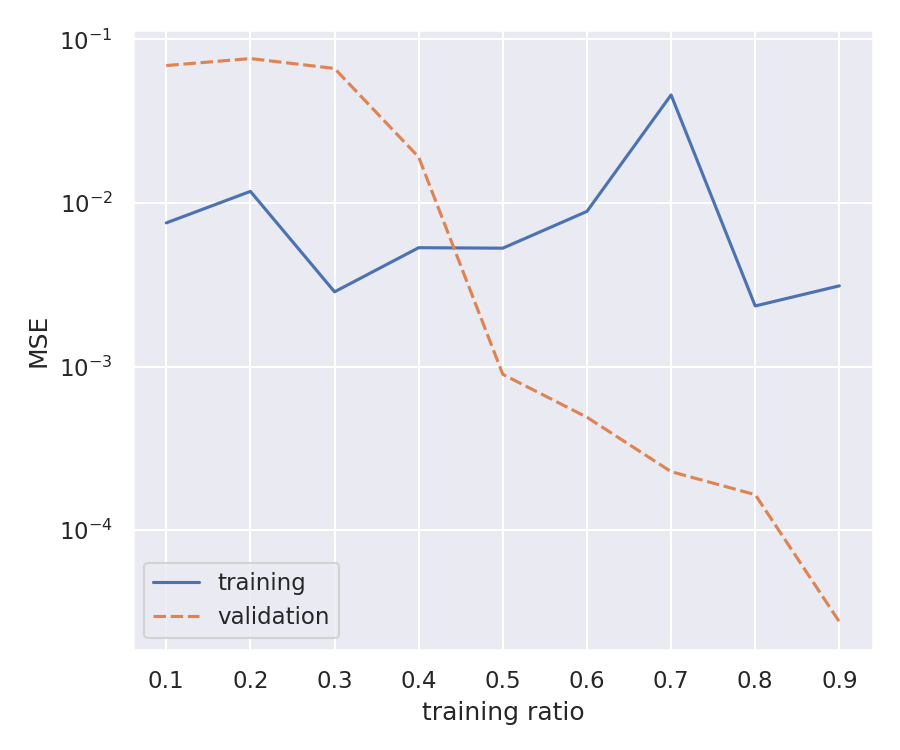

In [111]:
from IPython.display import Image
Image('./img/{}.png'.format(OUTPUT), width=480)

## Aggregate

For simplicity reload all the metrics and show in a table the results:

In [170]:
import json

with open('./metrics/ridge_train.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_train.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_train.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_train.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_train.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_train.json', 'r') as f:
    ann = json.load(f)
    
metrics_train = {'MSE':    [np.round(m['MSE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 3), np.round(m['MSE 95% CI (upper)'], 3)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 3) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_train = pd.DataFrame(metrics_train, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [172]:
print('Training metrics:\n')
metrics_train

Training metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.175,"(0.134, 0.216)",0.418,0.306,0.650
l-SVR,2.475,"(1.239, 3.711)",1.573,0.477,-3.953
r-SVR,0.053,"(0.025, 0.081)",0.231,0.092,0.893
RF,0.024,"(0.013, 0.035)",0.154,0.043,0.953
GBDT,0.005,"(0.002, 0.007)",0.069,0.023,0.990
ANN,0.001,"(-0.0, 0.003)",0.035,0.008,0.998


In [173]:
import json

with open('./metrics/ridge_val.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_val.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_val.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_val.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_val.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_val.json', 'r') as f:
    ann = json.load(f)
    
metrics_val = {'MSE':    [np.round(m['MSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 5), np.round(m['MSE 95% CI (upper)'], 5)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_val = pd.DataFrame(metrics_val, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [174]:
print('Validation metrics:\n')
metrics_val

Validation metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.10786,"(0.06687, 0.14885)",0.32842,0.26839,0.77626
l-SVR,1.39160,"(-0.48978, 3.27297)",1.17966,0.38805,-1.88673
r-SVR,0.01932,"(0.00355, 0.03509)",0.13900,0.08069,0.95992
RF,0.00354,"(-4e-05, 0.00711)",0.05947,0.02430,0.99266
GBDT,0.00021,"(0.00012, 0.00031)",0.01452,0.00960,0.99956
ANN,0.00003,"(2e-05, 4e-05)",0.00569,0.00458,0.99993


In [175]:
import json

with open('./metrics/ridge_test.json', 'r') as f:
    ridge = json.load(f)
with open('./metrics/linearsvr_test.json', 'r') as f:
    linearsvr = json.load(f)
with open('./metrics/svr_test.json', 'r') as f:
    svr = json.load(f)
with open('./metrics/rf_lgbmregressor_test.json', 'r') as f:
    rf = json.load(f)
with open('./metrics/gbdt_lgbmregressor_test.json', 'r') as f:
    gbdt = json.load(f)
with open('./metrics/ann_model_test.json', 'r') as f:
    ann = json.load(f)
    
metrics_test = {'MSE':    [np.round(m['MSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '95% CI': [(np.round(m['MSE 95% CI (lower)'], 5), np.round(m['MSE 95% CI (upper)'], 5)) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'RMSE':   [np.round(m['RMSE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 'MAE':    [np.round(m['MAE'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                 '$r^2$':  [np.round(m['R2'], 5) for m in [ridge, linearsvr, svr, rf, gbdt, ann]],
                }
metrics_test = pd.DataFrame(metrics_test, index=['LR ($\ell_2$ reg.)', 'l-SVR', 'r-SVR', 'RF', 'GBDT', 'ANN'])

In [176]:
print('Test metrics:\n')
metrics_test

Test metrics:



,MSE,95% CI,RMSE,MAE,$r^2$
LR ($\ell_2$ reg.),0.16020,"(0.07349, 0.24692)",0.40025,0.29223,0.68355
l-SVR,2.41621,"(-0.24859, 5.081)",1.55442,0.48745,-3.77280
r-SVR,0.02215,"(0.00748, 0.03682)",0.14883,0.08709,0.95625
RF,0.01105,"(-0.00276, 0.02486)",0.10512,0.03662,0.97817
GBDT,0.00118,"(0.00031, 0.00205)",0.03431,0.01730,0.99767
ANN,0.00005,"(2e-05, 7e-05)",0.00680,0.00505,0.99991
